# Census Income Classification (≤$50K vs >$50K)

**Goal:** To train + validate a binary classifier that predicts whether a person earns more than $50,000 using ~40 census-style demographic & employment variables from the 1994 and 1995 Current Population Surveys conducted by the U.S. Census Bureau.

## What we are looking for during our EDA

### Label + leakage checks
- Confirm label mapping is correct and stable (no trailing spaces, punctuation variants).
- Check whether any predictors directly encode income (leakage) — e.g., “income”, “tax liability”, or features computed from income.

### Missingness & “Not in universe” categories
- Census data often uses sentinel strings like **"Not in universe"**, **"?"**, **"Do not know"**.
- Treat these as legitimate categories (not necessarily “missing”) unless the data dictionary says otherwise.

### Skewed numeric distributions
- Many monetary variables are **spike-at-zero + long tail** (capital gains/losses, dividends, wage/hour).
- Two useful transforms:
  1) an **indicator**: `x > 0`
  2) a **log transform** for positives: `log1p(x)`

### High-cardinality categories & dimensionality
- Some columns have many distinct values (e.g., `weight` has ~100k unique values in your counts).
- One-hot encoding everything naively can explode feature dimensionality, slow training, and overfit.
- You should quantify: `n_unique` per column and estimated post-OHE dimension.

### Imbalance-aware metrics
Accuracy can look “great” by predicting the majority class.
Prefer:
- **PR-AUC (Average Precision)**: best when positive class is rare
- **balanced accuracy**
- **F1** (or Fβ if business prefers precision vs recall)
- **confusion matrix at a chosen decision threshold**


## 1) Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay
)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

from helper import column_summary, plot_feature_vs_label

RANDOM_STATE = 42

## 2) Load data

In [20]:
DATA_PATH = "census-bureau.data"
COLUMNS_PATH = "census-bureau.columns"

# read in columns
with open(COLUMNS_PATH, "r") as f:
    columns = [line.strip() for line in f if line.strip()]

census_df = pd.read_csv(DATA_PATH, header=None, names=columns)
print("Dataset shape:", census_df.shape)
display(census_df.head(5))

Dataset shape: (199523, 42)


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


### Basic sanity checks

In [ ]:
# check for duplicate rows & drop them
dup_rows = census_df.duplicated().sum()
print("Duplicate rows:", dup_rows)
if dup_rows > 0:
    census_df = census_df.drop_duplicates().reset_index(drop=True)
    print("Dataset shape after dropping duplicates:", census_df.shape)
    
# check for missing values (only NaNs right now but may have other placeholders that require visual inspection)
na_counts = census_df.isna().sum().sort_values(ascending=False)
display(na_counts[na_counts > 0].to_frame("na_count"))

# drop nans since they represent a small fraction of the data
census_df = census_df.dropna().reset_index(drop=True)
print("Dataset shape after dropping NaNs:", census_df.shape)

Duplicate rows: 3229
Dataset shape after dropping duplicates: (196294, 42)


,na_count
hispanic origin,870


Dataset shape after dropping NaNs: (195424, 42)


## 3) Label analysis

Labels are currently strings that we can convert to boolean
- `"- 50000."`  → 0
- `"50000+."`   → 1

We can also see that the distribution is heavily skewed (majority ≤$50K).  

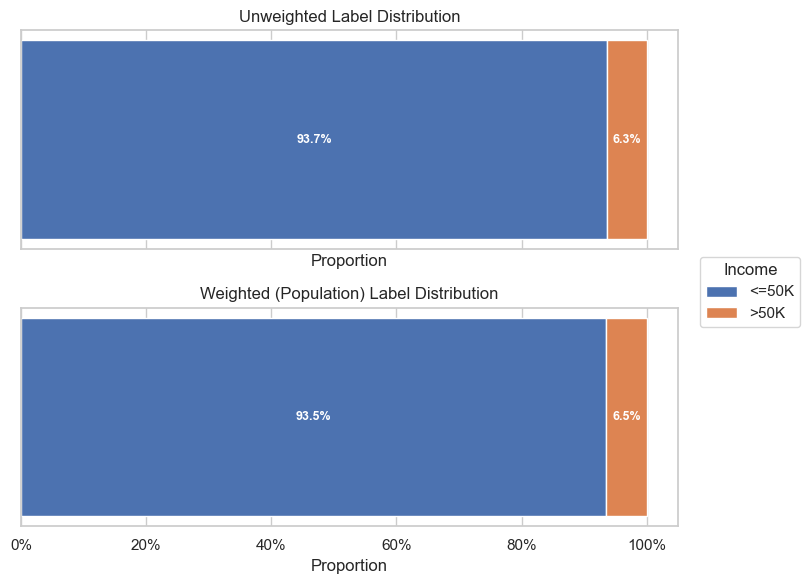

In [ ]:
LABEL_COL = "label"
WEIGHT_COL = "weight"

# map labels
label_raw = census_df[LABEL_COL].astype(str).str.strip()
label_map = {"- 50000.": 0, "50000+.": 1}
X = census_df.copy().drop(columns=[LABEL_COL])
y = label_raw.map(label_map)

labels = ["<=50K", ">50K"]
palette = sns.color_palette("deep", 2)

# compute proportions
unweighted_rates = y.value_counts().sort_index()
unweighted_rates = unweighted_rates / unweighted_rates.sum()

weighted_rates = (
    census_df.assign(label=y)
    .groupby("label")[WEIGHT_COL]
    .sum()
)
weighted_rates = weighted_rates / weighted_rates.sum()
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# ========= UNWEIGHTED =========
left = 0
for i, val in enumerate(unweighted_rates.values):
    axes[0].barh(
        y=0,
        width=val,
        left=left,
        color=palette[i],
        label=labels[i]
    )

    axes[0].text(
        left + val / 2,
        0,
        f"{val:.1%}",
        ha="center",
        va="center",
        fontsize=9,
        color="white",
        fontweight="bold"
    )

    left += val

axes[0].set_title("Unweighted Label Distribution")
axes[0].set_yticks([])
axes[0].set_xlabel("Proportion")
axes[0].xaxis.set_major_formatter(ticker.PercentFormatter(1.0))


# ========= WEIGHTED =========
left = 0
for i, val in enumerate(weighted_rates.values):
    axes[1].barh(
        y=0,
        width=val,
        left=left,
        color=palette[i],
        label=labels[i]
    )

    axes[1].text(
        left + val / 2,
        0,
        f"{val:.1%}",
        ha="center",
        va="center",
        fontsize=9,
        color="white",
        fontweight="bold"
    )

    left += val

axes[1].set_title("Weighted (Population) Label Distribution")
axes[1].set_yticks([])
axes[1].set_xlabel("Proportion")
axes[1].xaxis.set_major_formatter(ticker.PercentFormatter(1.0))

handles, legend_labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    legend_labels,
    title="Income",
    loc="center right",
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()


Even after weighting, the proportion of individuals earning more than $50K remains around 6% so the class imbalance reflects the true population rather than sampling bias. We will drop the `weight` variable for modeling since our goal is individual-level prediction (and this variable would not be available at inference time).

Furthermore, because of the label imbalance, a “dumb” classifier that always predicts `<=50K` would achieve ~94% accuracy but have 0 recall on the minority class so we will evaluate with PR-AUC, balanced accuracy, and F1 (and not just accuracy).


## 4) Analyzing Indvidual Columns

In [23]:
summary_df = column_summary(census_df)
summary_df

,column,dtype,n_unique,special_values,unique_values
0,age,int64,91,,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]"
1,class of worker,object,9,not in universe: 96588,"[Federal government, Local government, Never worked, Not in universe, Private, Self-employed-incorporated, Self-employed-not incorporated, State government, Without pay]"
2,detailed industry recode,int64,52,,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]"
3,detailed occupation recode,int64,47,,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]"
4,education,object,17,,"[10th grade, 11th grade, 12th grade no diploma, 1st 2nd 3rd or 4th grade, 5th or 6th grade, 7th and 8th grade, 9th grade, Associates degree-academic program, Associates degree-occup /vocational, Bachelors degree(BA AB BS), Children, Doctorate degree(PhD EdD), High school graduate, Less than 1st grade, Masters degree(MA MS MEng MEd MSW MBA), Prof school degree (MD DDS DVM LLB JD), Some college but no degree]"
5,wage per hour,int64,1240,,"[0, 20, 70, 75, 100, 110, 125, 135, 143, 150, 170, 173, 190, 200, 205, 210, 212, 213, 215, 220, 225, 230, 232, 233, 234, 235, 245, 250, 252, 255, 260, 270, 275, 285, 289, 290, 294, 300, 303, 305, 310, 313, 325, 327, 333, 345, 350, 355, 365, 367, 375, 380, 385, 390, 400, 410, 415, 417, 420, 425, 427, 429, 430, 432, 435, 438, 440, 442, 443, 445, 446, 447, 448, 449, 450, 451, 455, 458, 460, 465, 466, 468, 470, 472, 473, 474, 475, 480, 483, 485, 486, 487, 489, 490, 491, 492, 493, 495, 496, 497, ...]"
6,enroll in edu inst last wk,object,3,not in universe: 182936,"[College or university, High school, Not in universe]"
7,marital stat,object,7,,"[Divorced, Married-A F spouse present, Married-civilian spouse present, Married-spouse absent, Never married, Separated, Widowed]"
8,major industry code,object,24,not in universe: 97025,"[Agriculture, Armed Forces, Business and repair services, Communications, Construction, Education, Entertainment, Finance insurance and real estate, Forestry and fisheries, Hospital services, Manufacturing-durable goods, Manufacturing-nondurable goods, Medical except hospital, Mining, Not in universe or children, Other professional services, Personal services except private HH, Private household services, Public administration, Retail trade, Social services, Transportation, Utilities and sanitary services, Wholesale trade]"
9,major occupation code,object,15,not in universe: 97025,"[Adm support including clerical, Armed Forces, Executive admin and managerial, Farming forestry and fishing, Handlers equip cleaners etc , Machine operators assmblrs & inspctrs, Not in universe, Other service, Precision production craft & repair, Private household services, Professional specialty, Protective services, Sales, Technicians and related support, Transportation and material moving]"


## Looking at value counts of categorical columns

In [ ]:
output_path = "value_counts.txt"
non_numeric_cols = census_df.select_dtypes(exclude=["number"]).columns
numeric_cols = census_df.select_dtypes(include=["number"]).columns

with open(output_path, "w") as f:
    for col in non_numeric_cols:
        f.write("=" * 80 + "\n")
        f.write(f"Column: {col}\n")
        f.write("-" * 80 + "\n")

        vc = census_df[col].value_counts(dropna=False)

        # compute column widths for alignment
        value_width = max(len(repr(v)) for v in vc.index)
        count_width = max(len(str(c)) for c in vc.values)

        total = vc.sum()

        for val, count in vc.items():
            pct = count / total
            f.write(
                f"{repr(val).ljust(value_width)}  "
                f"{str(count).rjust(count_width)}  "
                f"{pct:>7.2%}\n"
            )

        f.write("\n")

Some interesting things I noticed upon manual analysis of value_counts.txt:
- 15 columns (`class of worker`,  `enroll in edu inst last wk`, `major industry code`, `major occupation code`, `member of a labor union`, `reason for unemployment`, `region of previous residence`, `state of previous residence`, `migration code-change in msa`, `migration code-change in reg`, `migration code-move within reg`, `migration prev res in sunbelt`, `family members under 18` `fill inc questionnaire for veteran's admin`) all contain a "not in universe" category. We can't say for certain that this is an imputation for NaNs just yet but worth checking into using external sources. 
    - One hunch I have is that this might refer to folks who are unemployed or children for the occupation related columns. The numbers are consistent for some columns (1xxxxx for `class of worker` and `major occupation code`)
    - For the second set of columns (migration related), we have the same number of values for each (1516)
    - For `region` and `state of previous residence`, they share the same number (183750). May indicate this value is for folks who did not have a previous residence.
    - TLDR: this value doesn't seem to indicate random missingness or NaNs. It has an actual value related to the column for which it is a category.
- `education` contains many values for pre-HS education. We can examine the class split by category but my hunch is that it is fairly consistent across most of those categories. We can collapse them for simplicity.
- `hispanic origin` was the only column with actual NaNs (870).
- 8 columns (`state of previous residence`, `migration code-change in msa`, `migration code-change in reg`, `migration code-move within reg`, `migration prev res in sunbelt`, `country of birth father`, `country of birth mother`, `country of birth self`) that contain category '?'
    - `country of birth self` contains the same information as `citizenship` so we shall remove it due to high cardinality. 
- `live in this house 1 year ago` contains a category: 'Not in universe under 1 year old'
- Most columns are very highly skewed towards one or two values and we should do something to handle these. Some ideas:
    - For migration-related columns we can collapse to binary variables: mover, nonmover
    - We likely don't need all the extra detail from the `detailed household and family stat` since a majority of the columns contain less than 0.5% of observations and the data is captured more generally in `detailed household summary in household`;
    - Similar logic for `state of previous residence` vs `region of previous residence` (redundant + high dimensional column can be omitted)
- The industry / occupation code columns both contain a "detailed" and "major" version. The major is more general (less categories) and is free text. The "detailed" version is the specific code. We don't need both since they capture the same information. 
- We can do some feature engineering on top of the "country of birth" columns: either binary (foreign born vs. domestic) or split into broader regions (European-born, Asian-born, etc).

## 5) Predictor-by-predictor EDA

Performing initial EDA using minimal assumptions about feature types. This helps us identify sparsity, skewness, and high dimensionality. Based on this additional visual analysis, we can reclassify variables into numeric, categorical, or engineered forms for modeling. 

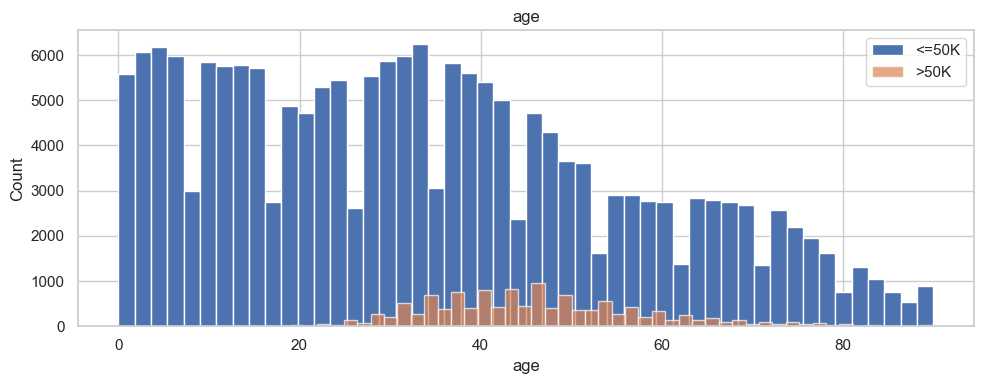

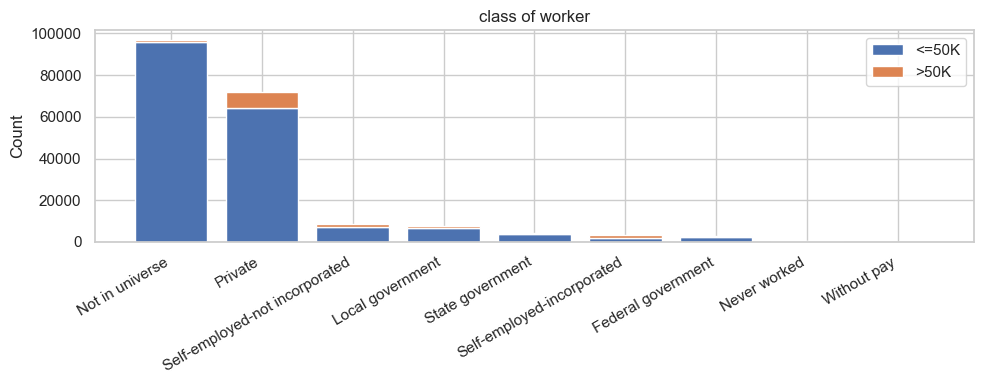

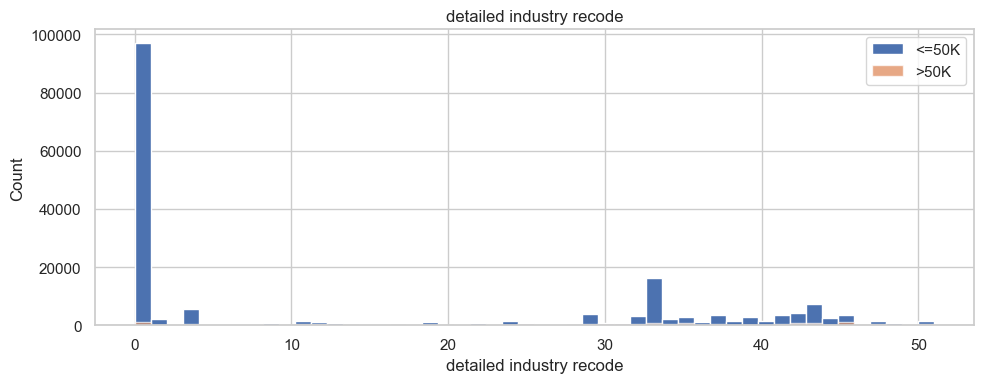

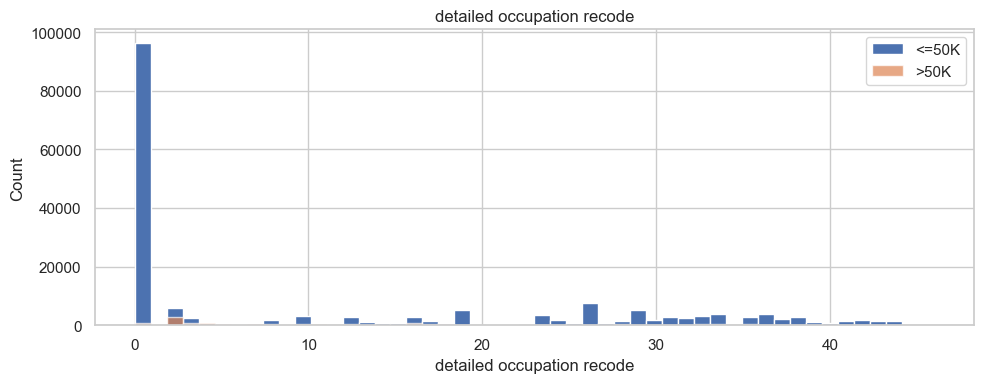

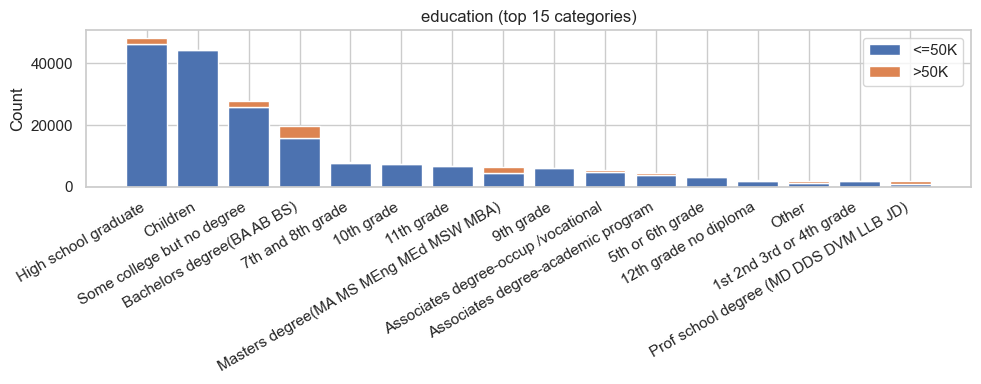

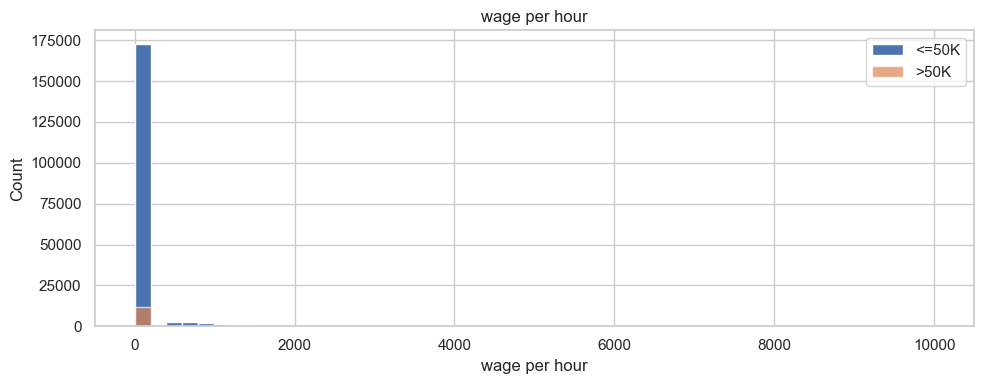

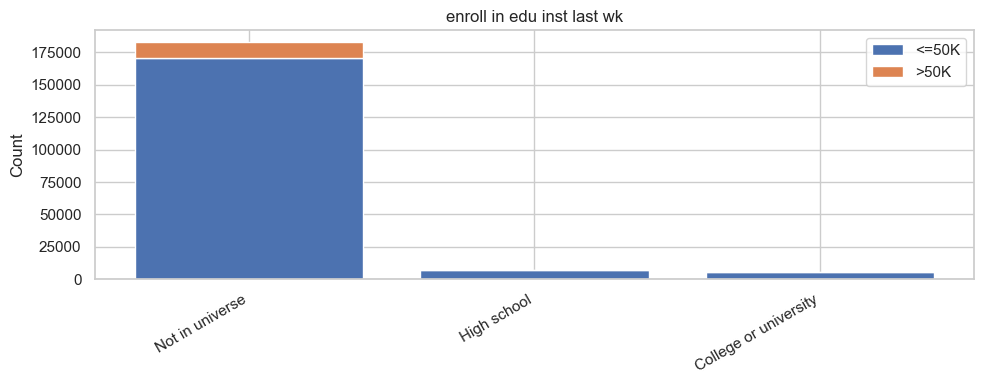

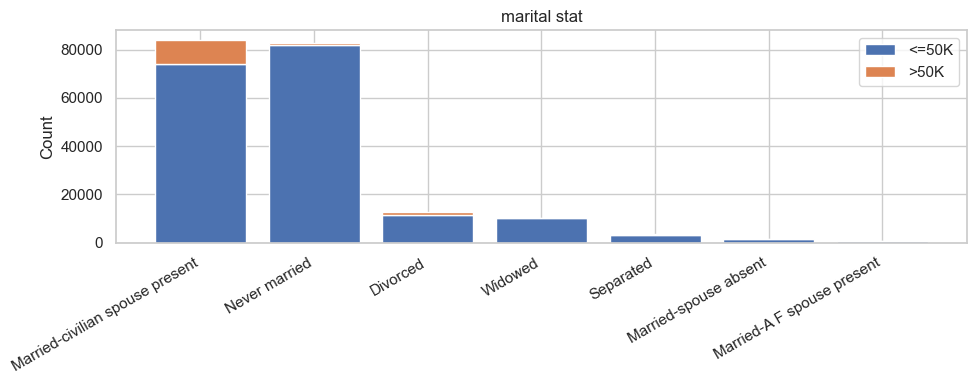

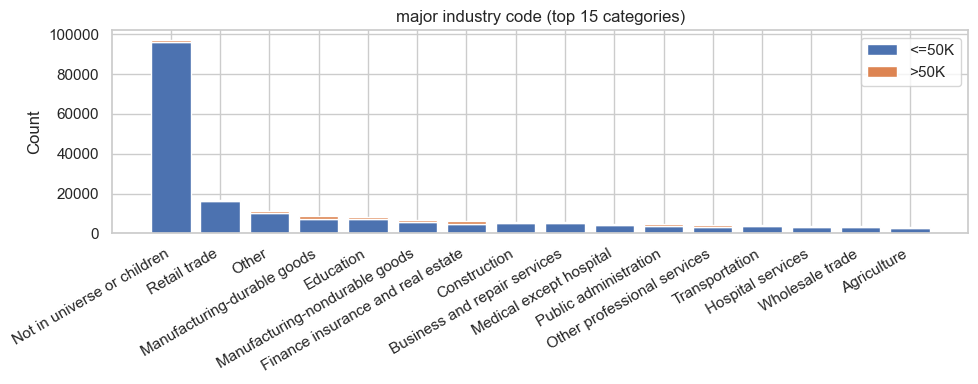

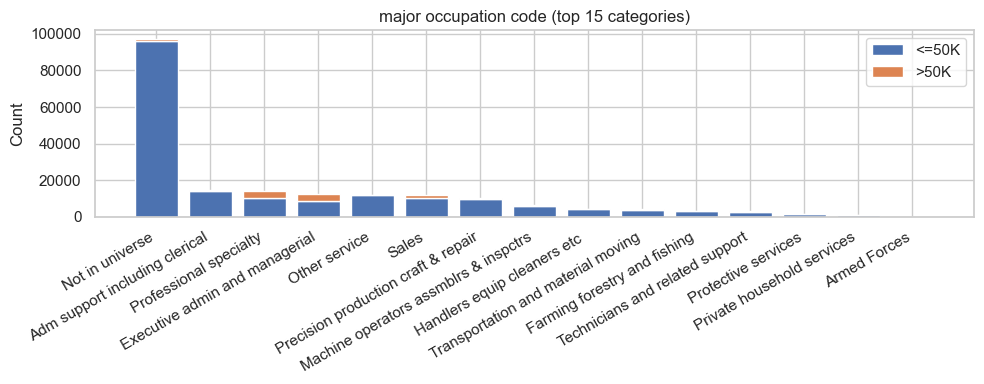

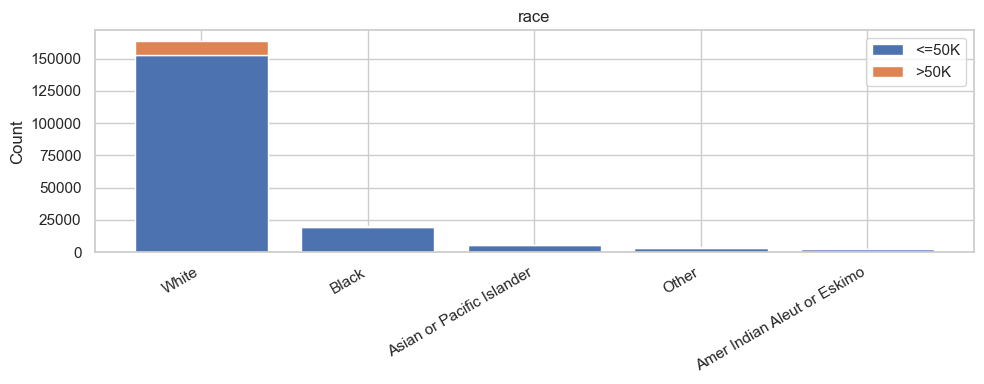

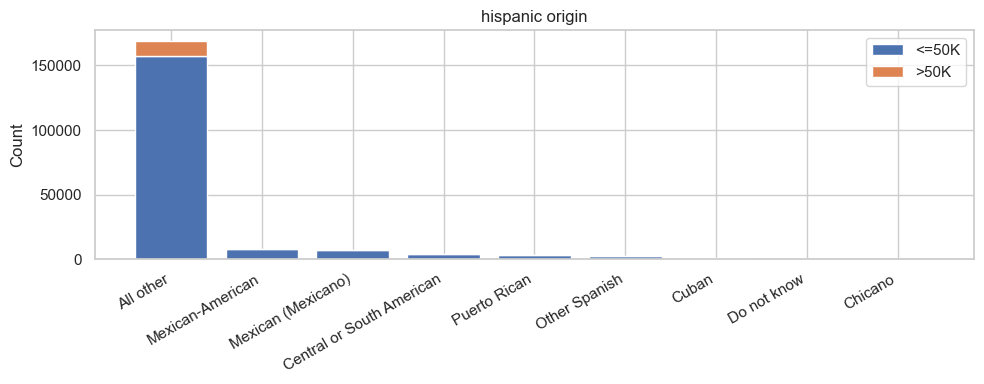

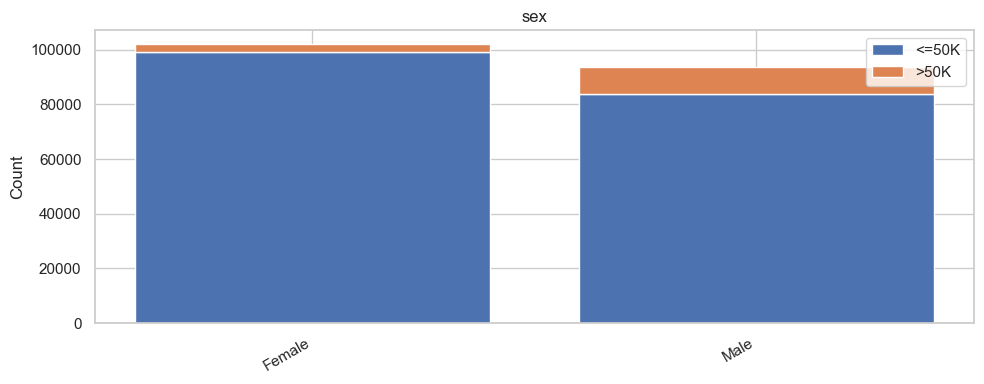

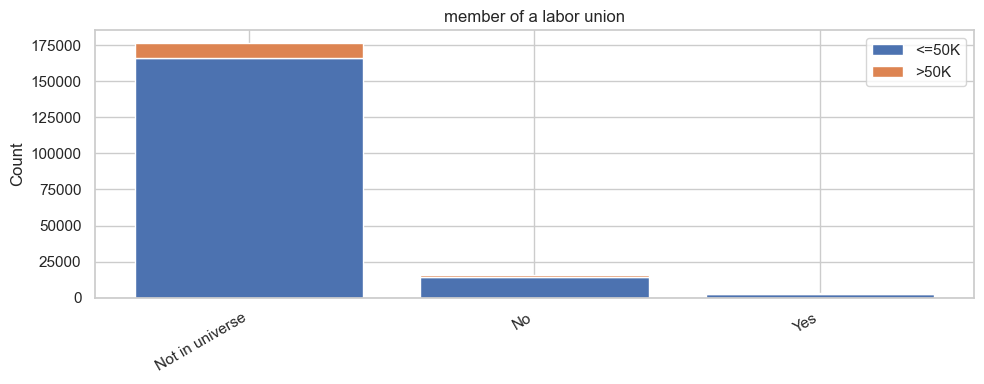

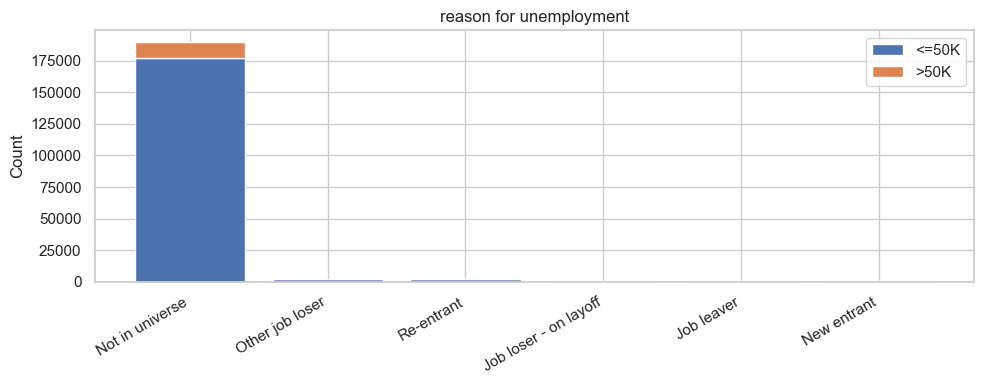

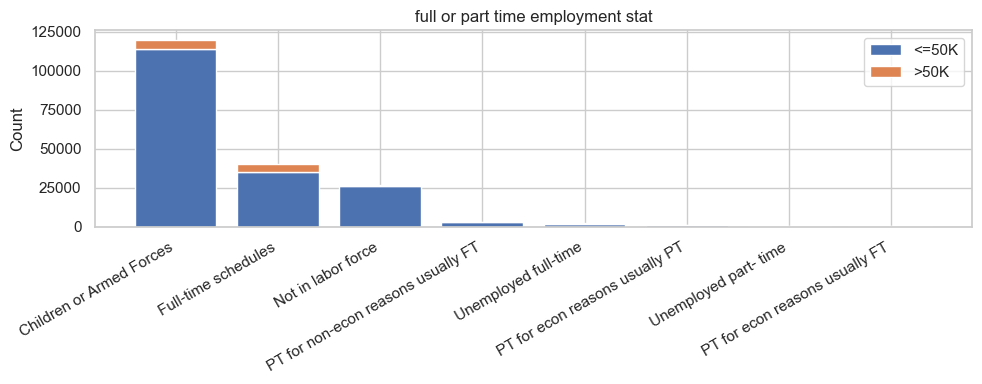

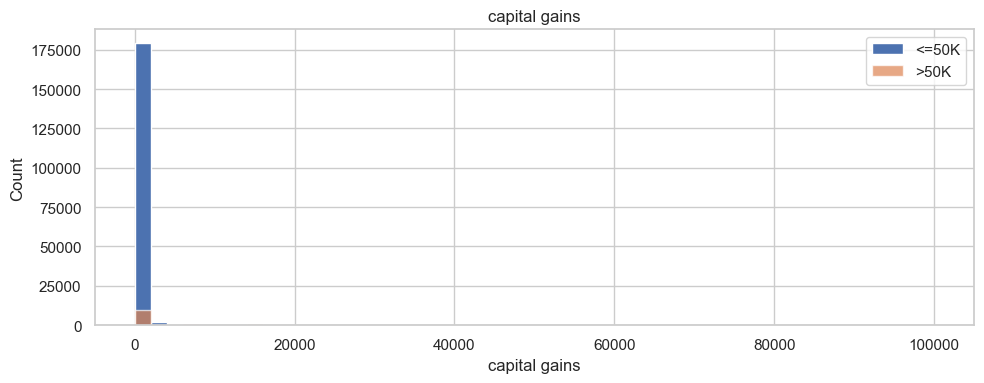

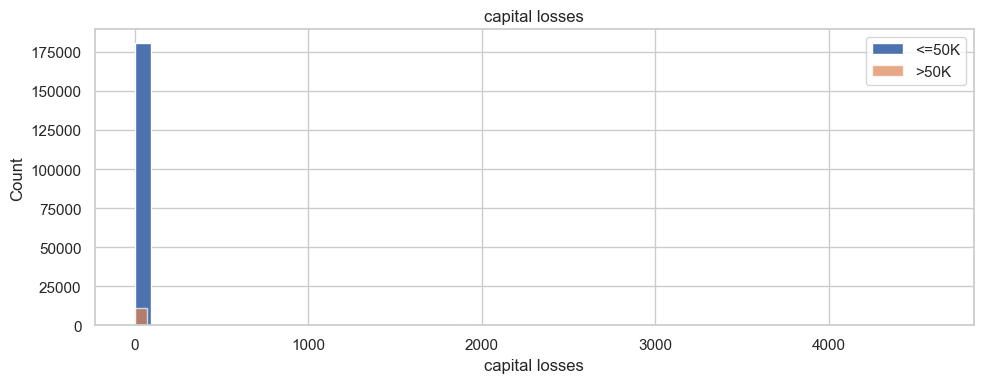

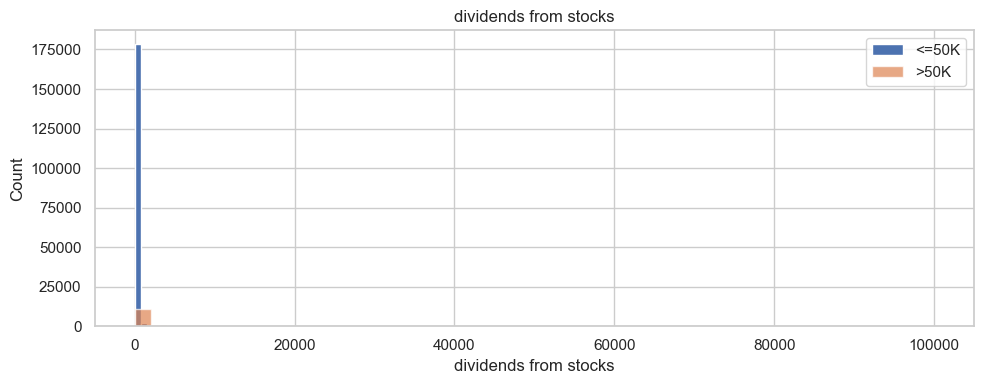

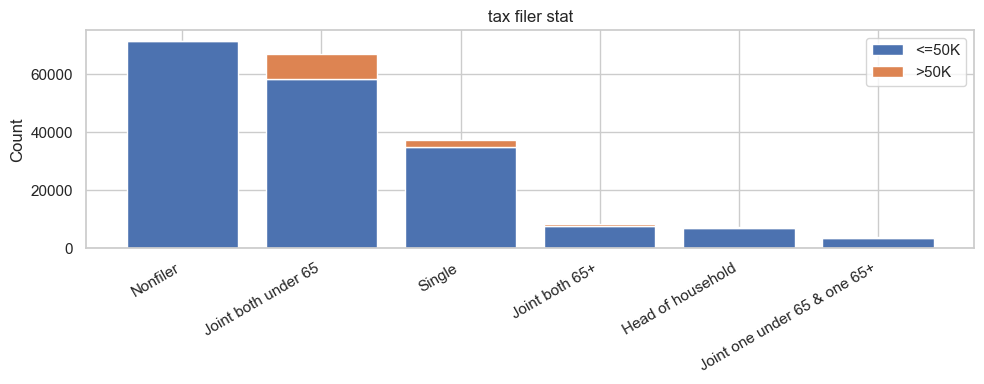

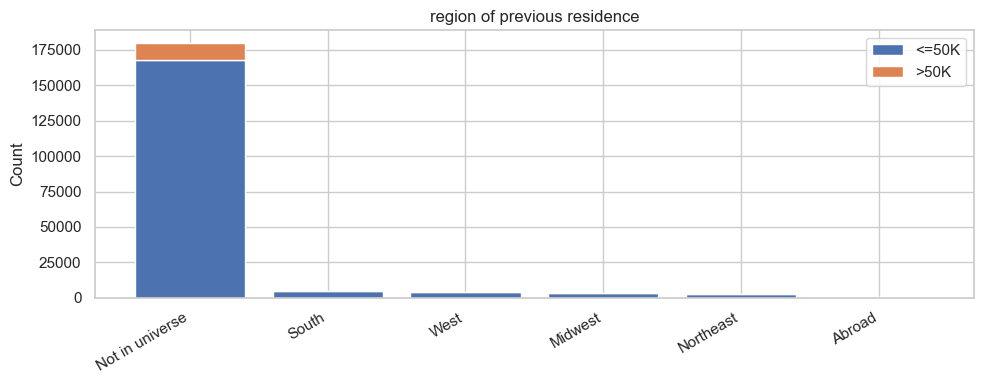

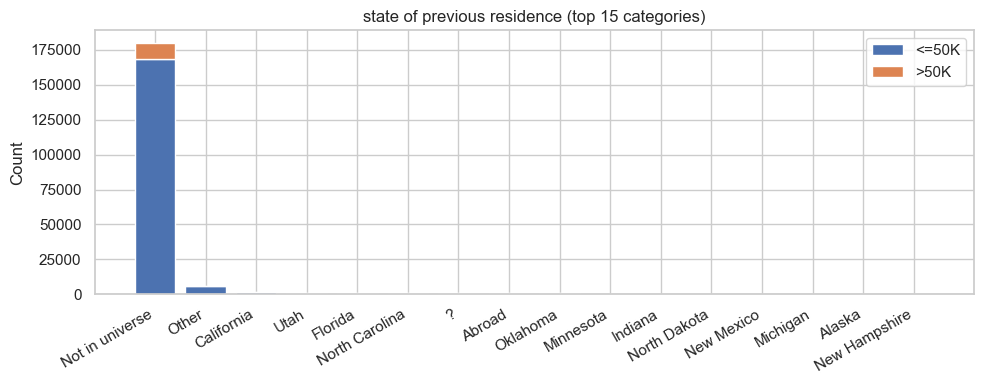

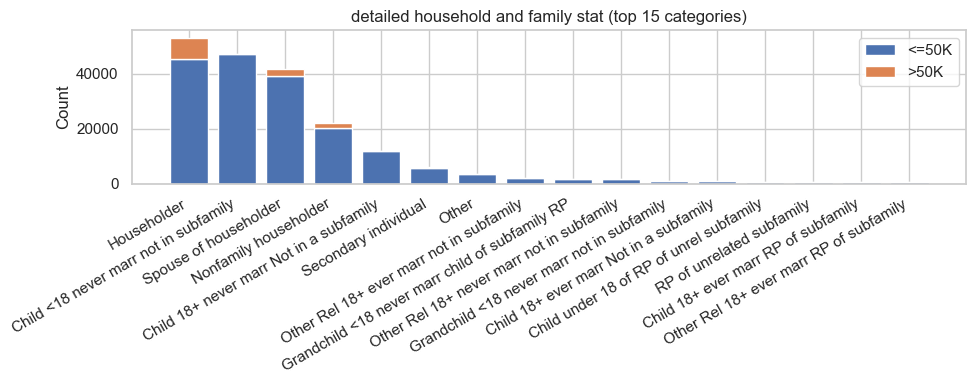

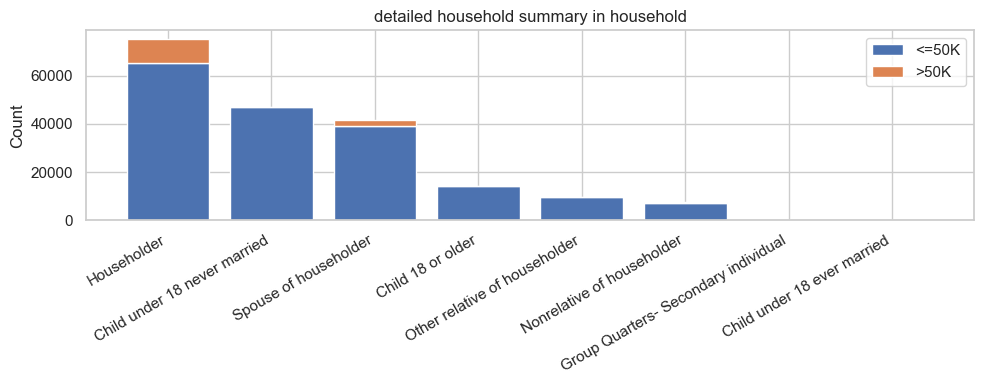

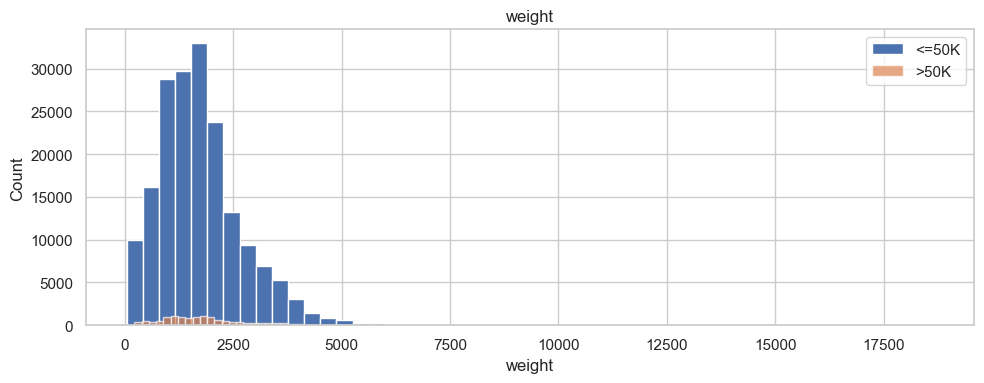

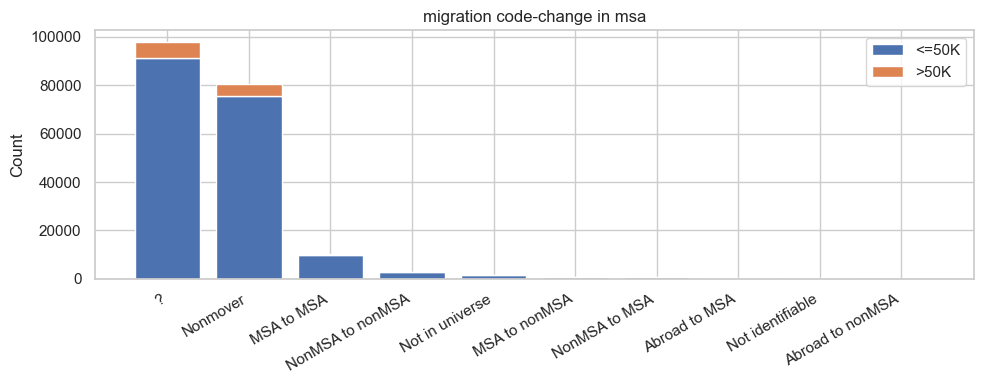

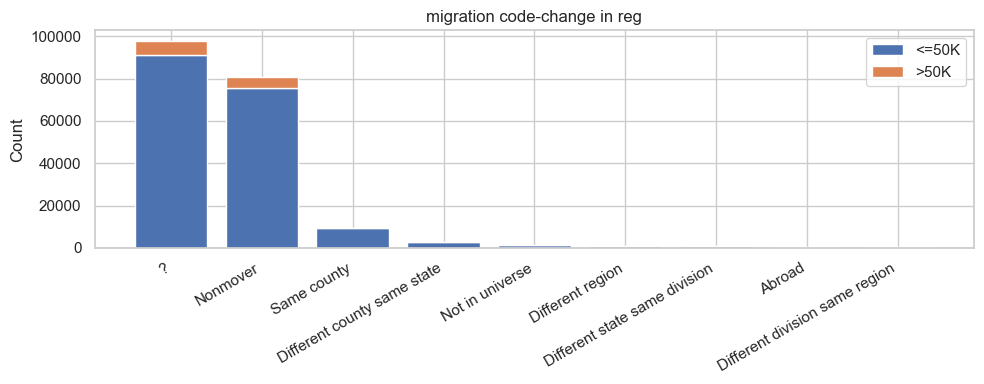

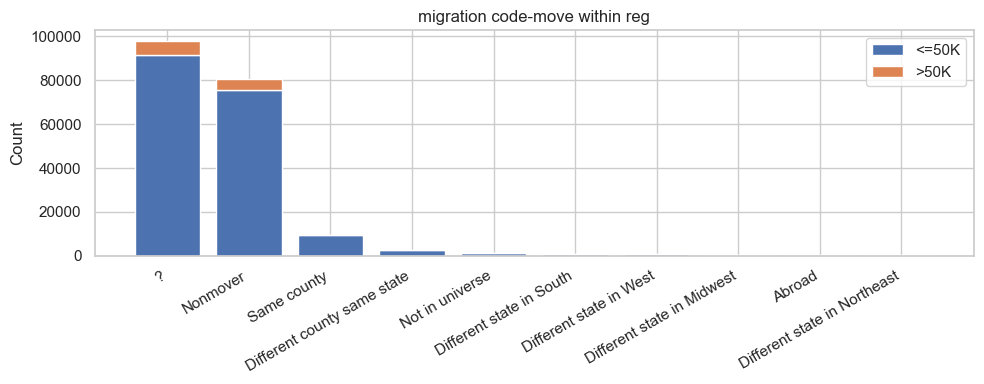

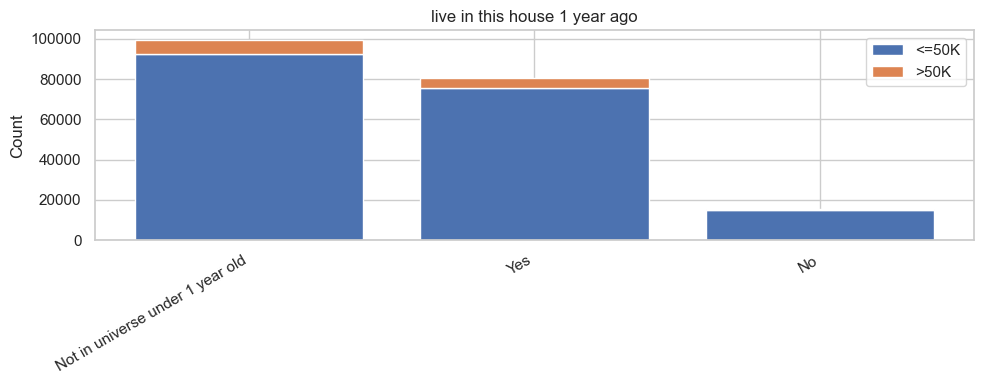

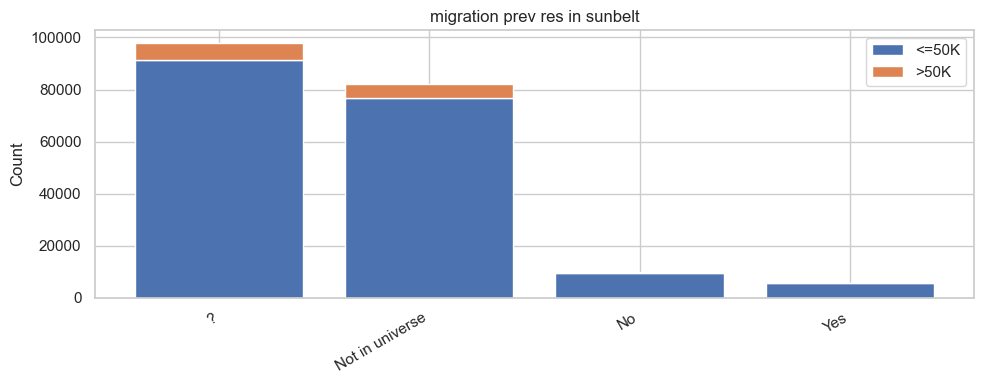

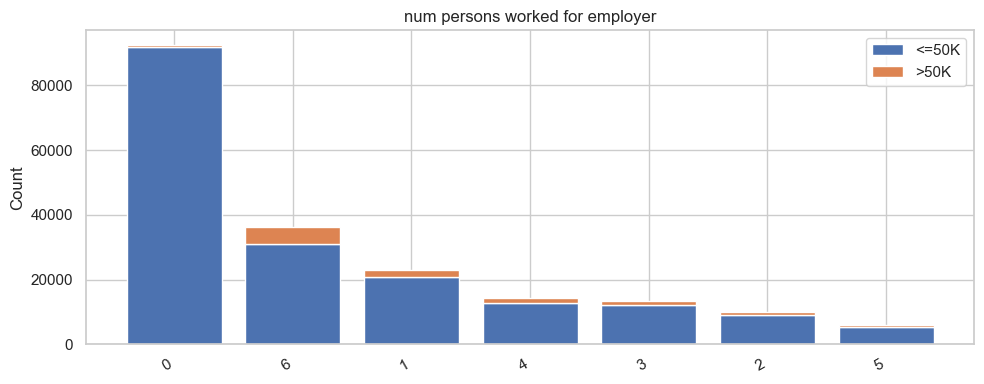

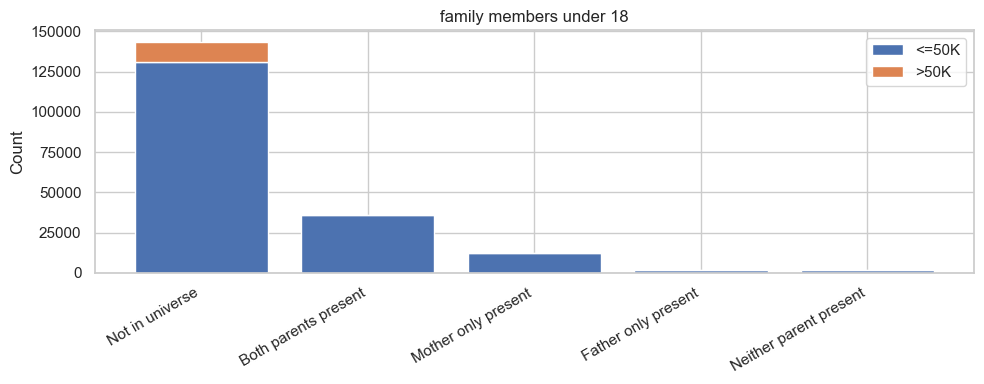

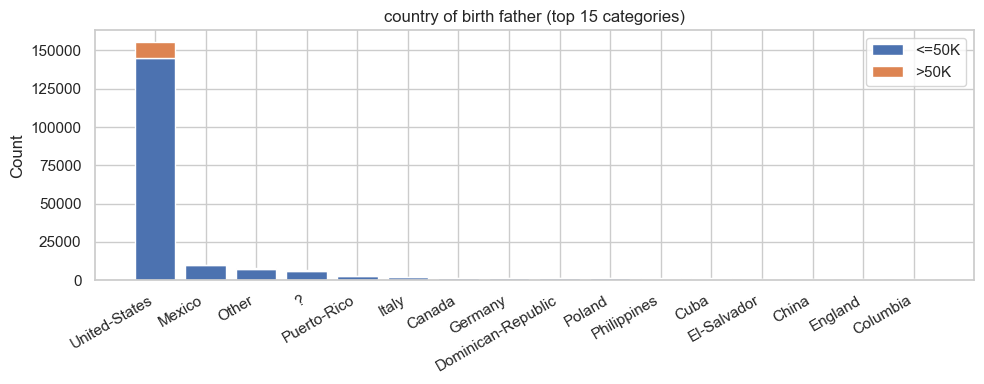

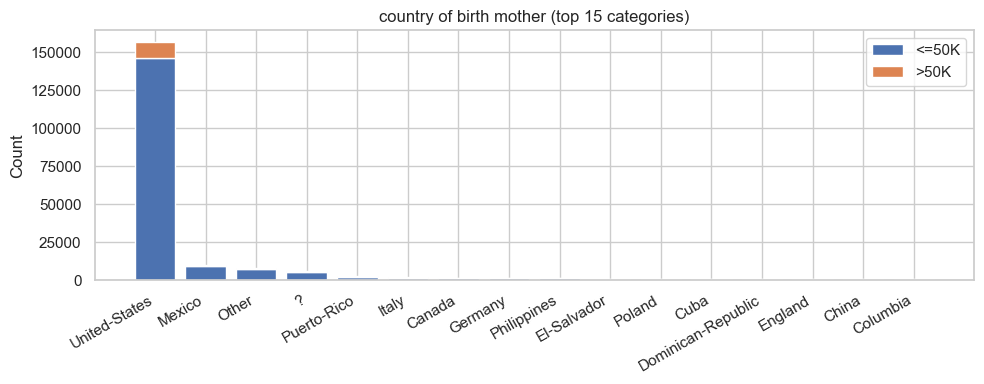

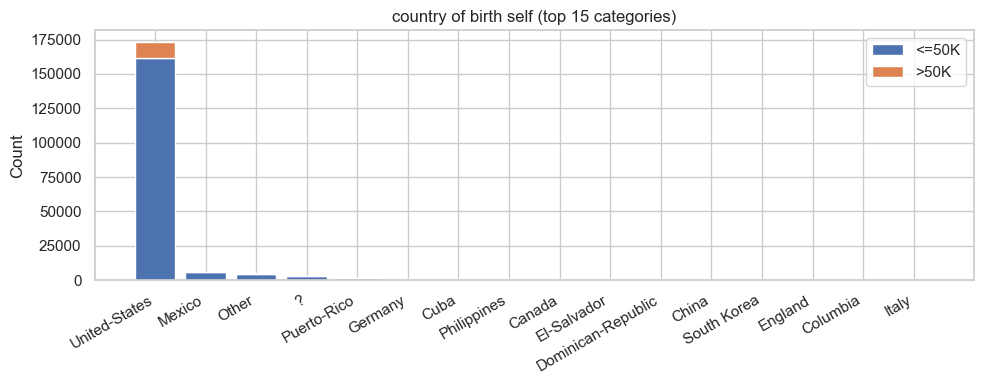

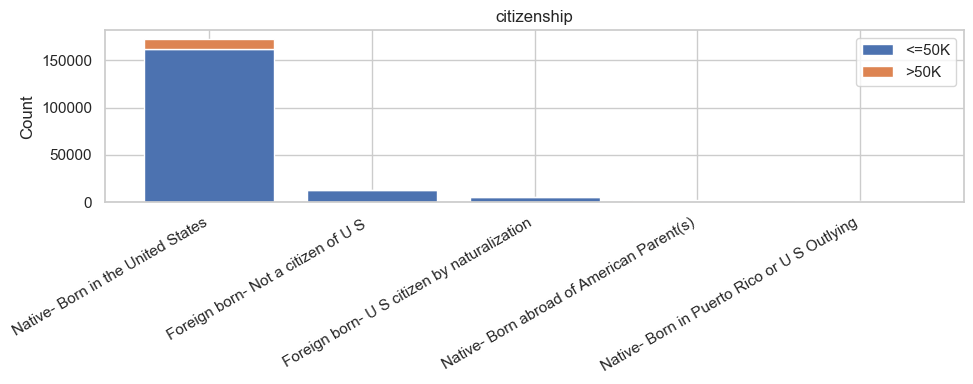

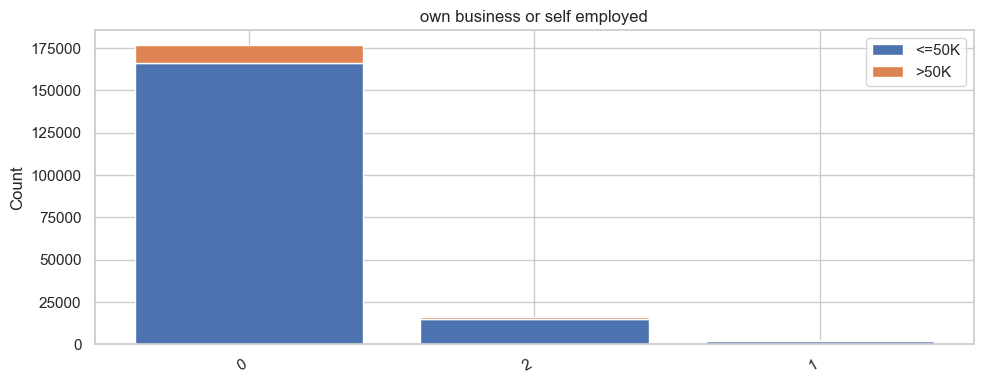

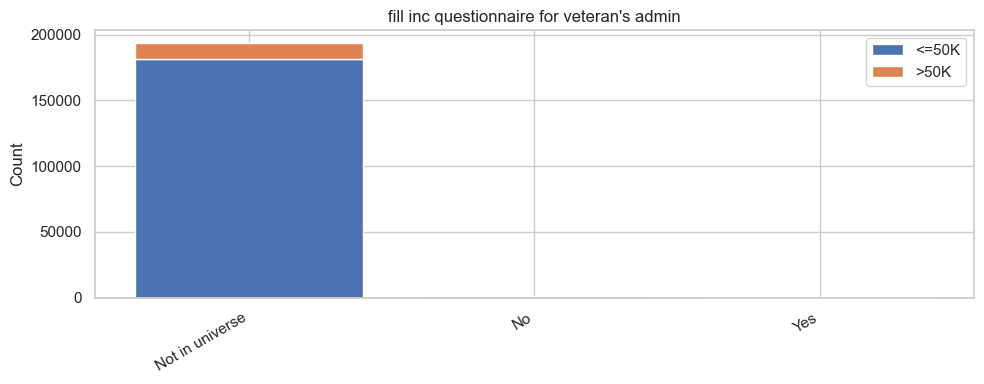

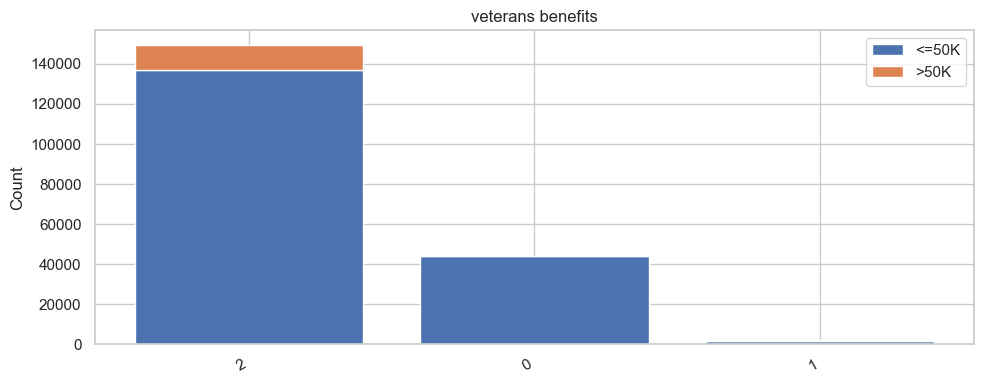

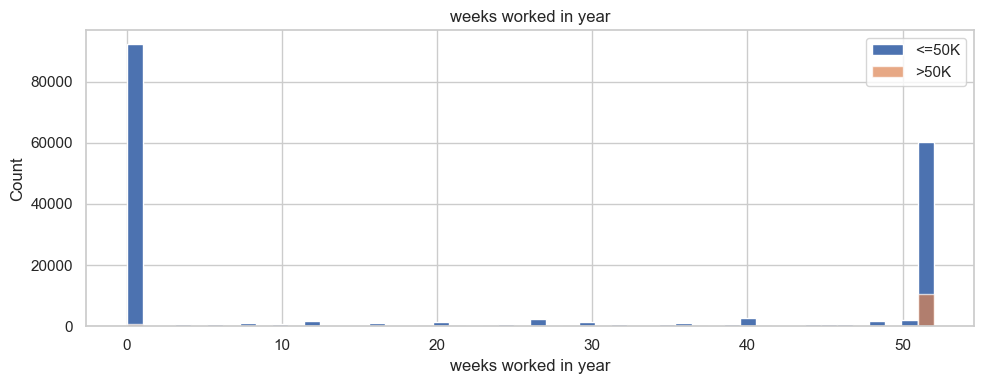

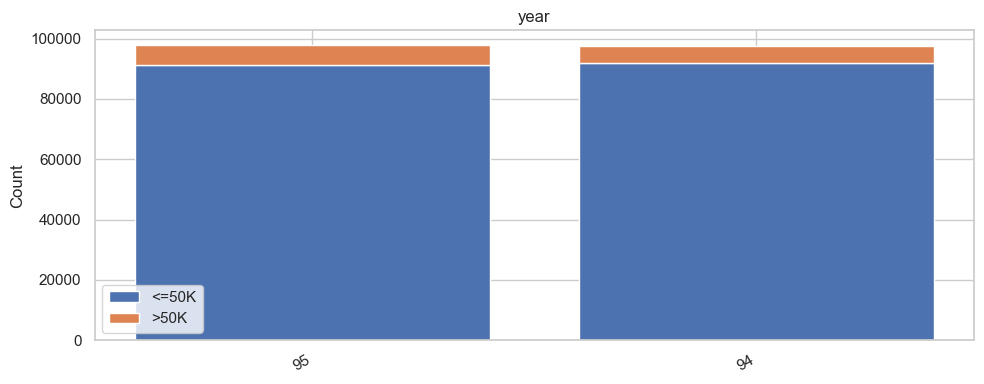

In [26]:
for f in X.columns:
    plot_feature_vs_label(X, y, f)

Based off this visual EDA, here are some design choices that we can make:
- All those making more than 50k are older than 18. We should exclude these datapoints from modeling since they are not part of the labor force and retaining them artificially inflates class imbalance.
- Most values for the industry and occupation recode are 0. High dimensional. We can drop these two columns in favor of the "major" versions which are less dimensional but capture the same information.
- Capital gains and losses are concentrated towards 0. May be worth looking at these columns with a log transformation. Same for dividends from stocks. Does it make sense to include a binary version of these into our model and then doing some EDA?
- Year only contains 2 values (94, 95). Not informative for a individual prediction model so we can drop this.
- Hispanic origin is heavily skewed towards "All other". This is a good feature for converting into a binary especially considering how current census and job applications handle this field (although it does raise ethical concerns). I err on the side of dropping demographic features completely. 
- Drop 'state of previous residence' since the same data is captured more generally in 'region of previous residence'.
- Drop 'detailed household and family stat' for 'detailed household summary in household' although i do notice one category that contains a noticeable difference across class split ('Nonfamily householder' in the first column is not present in the second)
- Create binary variables for Country of birth <father/mother/self> and convert to US born or not. Seems like this would have overlap with Hispanic origin. 
- Drop 'fill inc questionnaire for veteran's admin'. sparsely filled and heavily biased towards the uninformative 'not in universe' category.

## 6) Feature Engineering (based on EDA)

NOTE: first we drop children from the dataset as they are not wage earners.

* Drop
    * weight
    * year
    * detailed industry recode
    * detailed occupation recode
    * state of previous residence
    * detailed household and family stat
    * filled inc questionnaire for veteran's admin
    * hispanic origin
    * country of birth self
    * family members under 18
* Keep as numeric (transformations for skewed monetary variables and binary indicators for nonzero values)
    * age
    * weeks worked in year
    * capital gains
    * capital losses
    * dividends from stocks
* Keep as categorical
    * major industry code
    * major occupation code
    * class of worker
    * education
    * marital status
    * labor union membership
    * tax filer status
    * region of previous residence
    * migration-related fields (collapsed)
* New engineered features
    * `has_capital_gains`
    * `has_capital_losses`
    * `has_dividends`
    * `born_in_us` (from country of birth columns)
    * various migration columns 

In [27]:
X_fe = census_df.copy()
print("Original dataset shape:", X_fe.shape)

# drop children from the dataset
X_fe = X_fe[X_fe["age"] >= 18]
print("Dataset shape after dropping children:", X_fe.shape)

# drop unused columns
DROP_COLS = [
    "weight",
    "year",
    "detailed industry recode",
    "detailed occupation recode",
    "state of previous residence",
    "detailed household and family stat",
    "fill inc questionnaire for veteran's admin",
    "hispanic origin",
    "country of birth self",
    "family members under 18" # only applies to children which have been dropped
]

X_fe = X_fe.drop(columns=[c for c in DROP_COLS if c in X_fe.columns])

# capital-related transformations
for col in ["capital gains", "capital losses", "dividends from stocks"]:
    if col in X_fe.columns:
        X_fe[f"has_{col.replace(' ', '_')}"] = (X_fe[col] > 0).astype(int)
        X_fe[f"log_{col.replace(' ', '_')}"] = np.log1p(X_fe[col])
        X_fe.drop(columns=col, inplace=True)

# binary indicators for country of birth columns
def is_us_born(series):
    return series.astype(str).str.contains("united-states", case=False, na=False)

for col in [
    "country of birth father",
    "country of birth mother",
]:
    if col in X_fe.columns:
        X_fe[f"{col}_us_born"] = is_us_born(X_fe[col]).astype(int)
        X_fe = X_fe.drop(columns=col)

def engineer_migration_features(df):
    df = df.copy()

    cols = [
        "migration prev res in sunbelt",
        "migration code-change in msa",
        "migration code-change in reg",
        "migration code-move within reg",
    ]

    # Combine all migration info into one Series for logic
    combined = df[cols].astype(str).apply(lambda x: " | ".join(x), axis=1).str.lower()

    # Structural missing / not applicable
    df["migration_unknown"] = combined.str.contains(
        r"not in universe|\?",
        case=False,
        regex=True
    )

    # Movers vs non-movers
    df["is_mover"] = combined.str.contains(
        "msa to|nonmsa to|different|abroad|same county", regex=True
    )

    # Explicit non-movers
    df["is_nonmover"] = combined.str.contains("nonmover")

    # Moved within same state
    df["moved_within_state"] = combined.str.contains(
        "same county|same state", regex=True
    )

    # Clean logic consistency
    df["is_mover"] = (
        df["is_mover"] & ~df["is_nonmover"] & ~df["migration_unknown"]
    ).astype(int)

    df["is_nonmover"] = df["is_nonmover"].astype(int)
    df["moved_within_state"] = df["moved_within_state"].astype(int)
    df["migration_unknown"] = df["migration_unknown"].astype(int)

    # Drop original columns
    df = df.drop(columns=cols)

    return df

X_fe = engineer_migration_features(X_fe)

# education simplification
def collapse_education_levels(s: pd.Series) -> pd.Series:
    s = s.astype(str)

    less_than_hs = {
        "Less than 1st grade",
        "1st 2nd 3rd or 4th grade",
        "5th or 6th grade",
        "7th and 8th grade",
        "9th grade",
        "10th grade",
        "11th grade",
        "12th grade no diploma",
    }

    mapping = {
        "Children": "Children",
        **{k: "Less than high school" for k in less_than_hs},
        "High school graduate": "High school graduate",
        "Some college but no degree": "Some college",
        "Associates degree-academic program": "Associate degree",
        "Associates degree-occup /vocational": "Associate degree",
        "Bachelors degree(BA AB BS)": "Bachelor's degree",
        "Masters degree(MA MS MEng MEd MSW MBA)": "Graduate degree",
        "Doctorate degree(PhD EdD)": "Graduate degree",
        "Prof school degree (MD DDS DVM LLB JD)": "Graduate degree",
    }

    return s.map(mapping).fillna("Other / Unknown")


X_fe["education"] = collapse_education_levels(X_fe["education"])

# convert sex to binary (may exclude later due to sensitivity of feature)
sex_map = {"Female": 0,"Male": 1}
X_fe["is_male"] = X_fe["sex"].map(sex_map)
X_fe = X_fe.drop(columns=["sex"]) 

# convert race to binary (white vs non-white)
X_fe["is_white"] = X_fe["race"].astype(str).str.strip().str.lower().eq("white").astype(int)
X_fe.drop(columns=["race"], inplace=True)

# get label 
y_fe = X_fe[LABEL_COL].astype(str).str.strip().map(label_map)
X_fe = X_fe.drop(columns=[LABEL_COL])

print("Dataset shape after feature engineering:", X_fe.shape)

X_fe.head()

Original dataset shape: (195424, 42)
Dataset shape after dropping children: (142800, 42)
Dataset shape after feature engineering: (142800, 34)


,age,class of worker,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,member of a labor union,reason for unemployment,full or part time employment stat,tax filer stat,region of previous residence,detailed household summary in household,live in this house 1 year ago,num persons worked for employer,citizenship,own business or self employed,veterans benefits,weeks worked in year,has_capital_gains,log_capital_gains,has_capital_losses,log_capital_losses,has_dividends_from_stocks,log_dividends_from_stocks,country of birth father_us_born,country of birth mother_us_born,migration_unknown,is_mover,is_nonmover,moved_within_state,is_male,is_white
0,73,Not in universe,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,Not in universe,Not in universe,Not in labor force,Nonfiler,Not in universe,Other relative of householder,Not in universe under 1 year old,0,Native- Born in the United States,0,2,0,0,0.000000,0,0.0,0,0.0,1,1,1,0,0,0,0,1
1,58,Self-employed-not incorporated,Some college,0,Not in universe,Divorced,Construction,Precision production craft & repair,Not in universe,Not in universe,Children or Armed Forces,Head of household,South,Householder,No,1,Native- Born in the United States,0,2,52,0,0.000000,0,0.0,0,0.0,1,1,0,1,0,1,1,1
2,18,Not in universe,Less than high school,0,High school,Never married,Not in universe or children,Not in universe,Not in universe,Not in universe,Not in labor force,Nonfiler,Not in universe,Child 18 or older,Not in universe under 1 year old,0,Foreign born- Not a citizen of U S,0,2,0,0,0.000000,0,0.0,0,0.0,0,0,1,0,0,0,0,0
5,48,Private,Some college,1200,Not in universe,Married-civilian spouse present,Entertainment,Professional specialty,No,Not in universe,Full-time schedules,Joint both under 65,Not in universe,Spouse of householder,Not in universe under 1 year old,1,Native- Born in the United States,2,2,52,0,0.000000,0,0.0,0,0.0,0,1,1,0,0,0,0,0
6,42,Private,Bachelor's degree,0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,Not in universe,Not in universe,Children or Armed Forces,Joint both under 65,Not in universe,Householder,Yes,6,Native- Born in the United States,0,2,52,1,8.552367,0,0.0,0,0.0,1,1,1,0,1,0,1,1


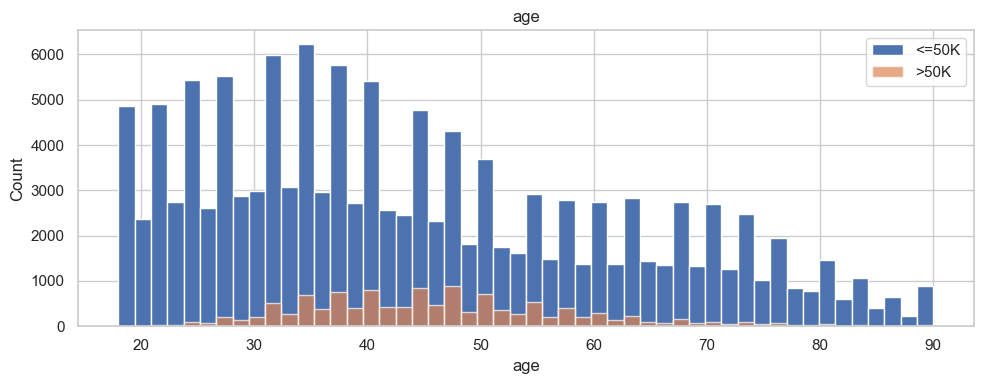

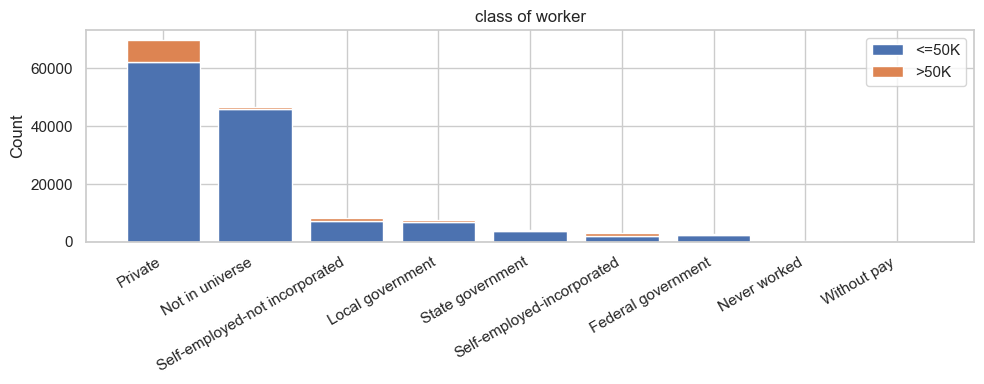

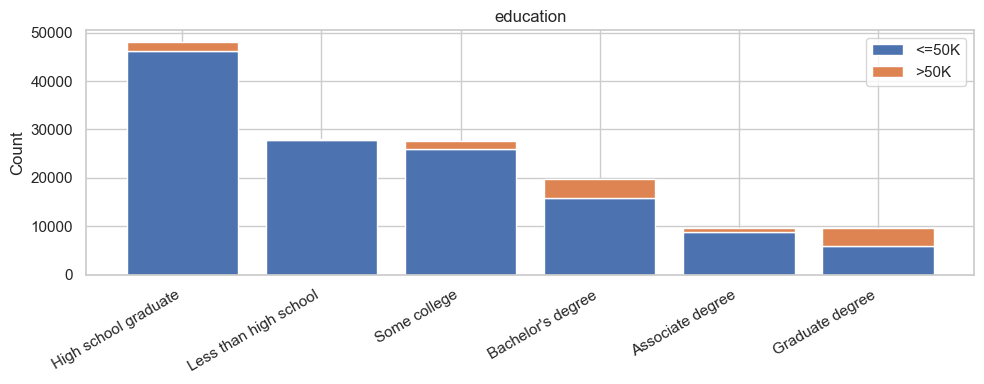

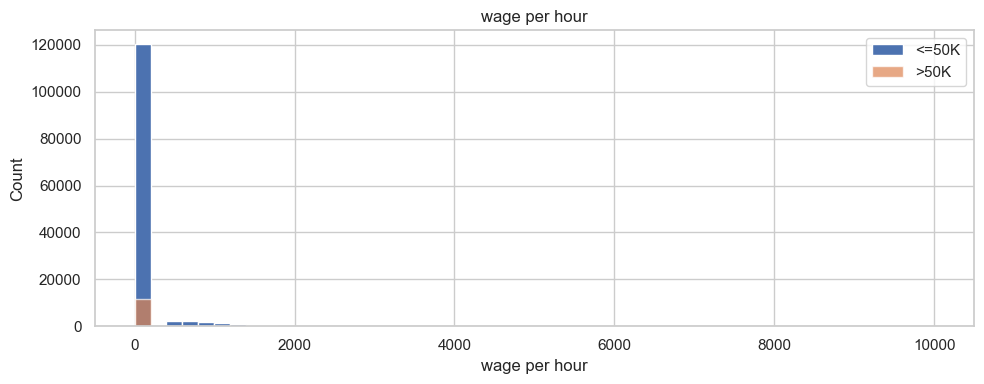

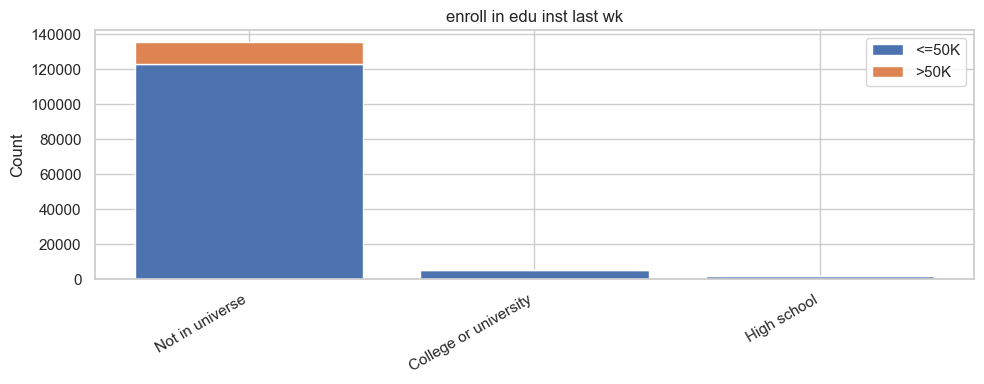

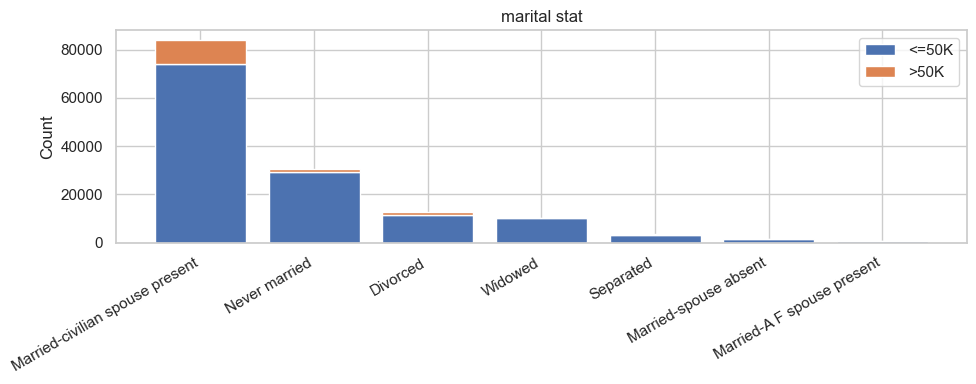

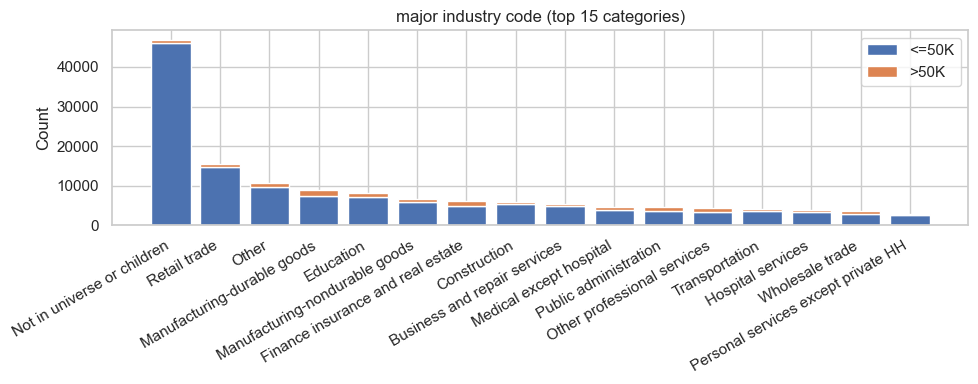

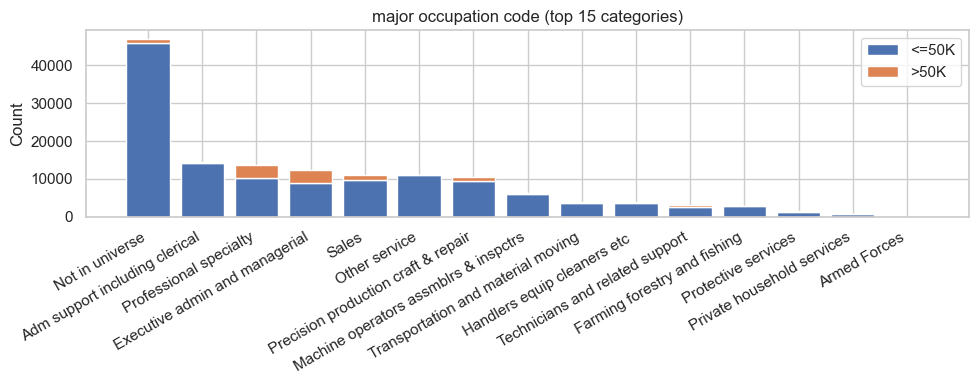

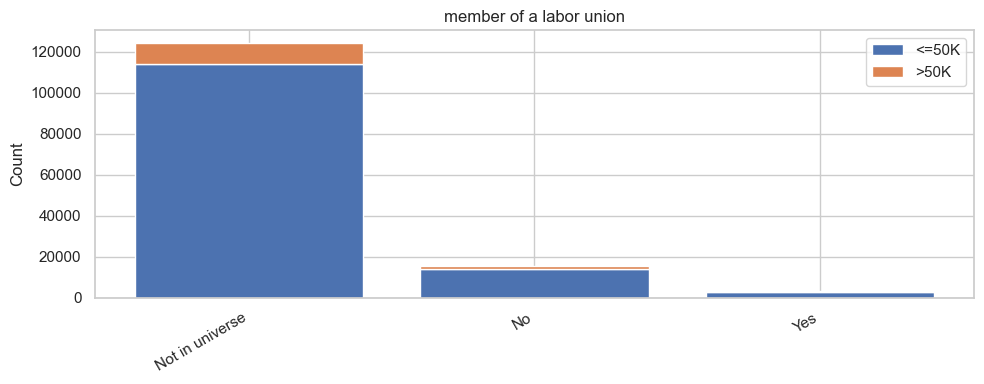

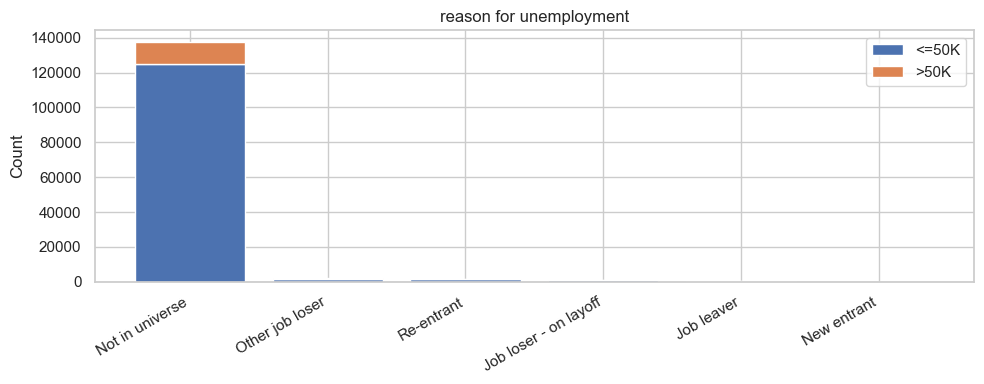

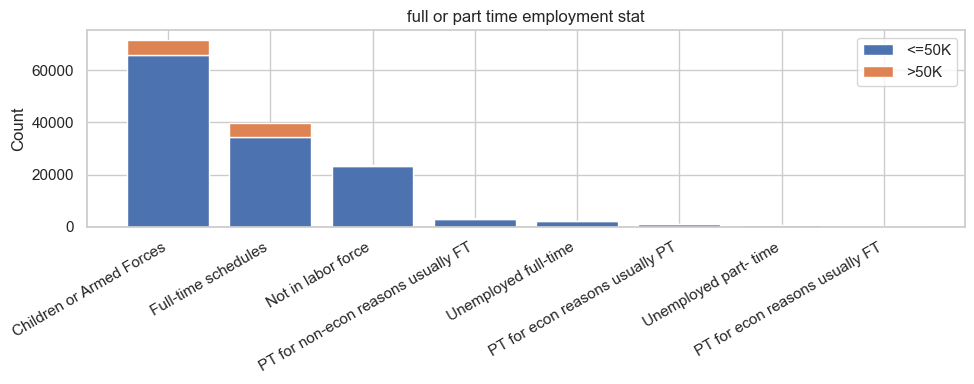

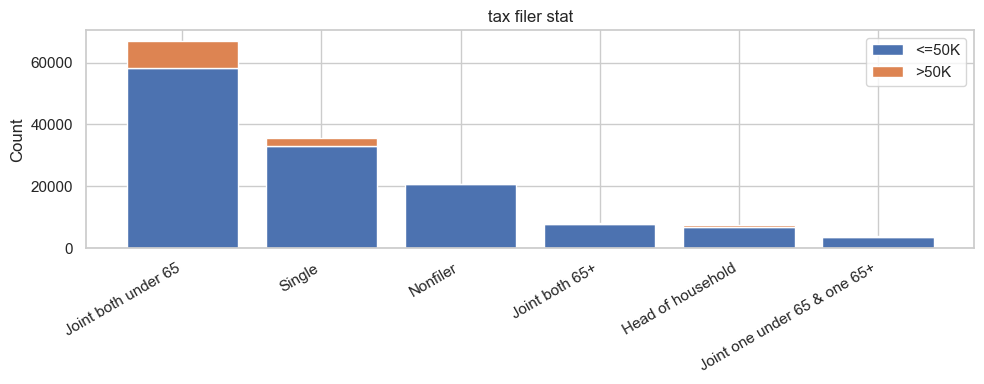

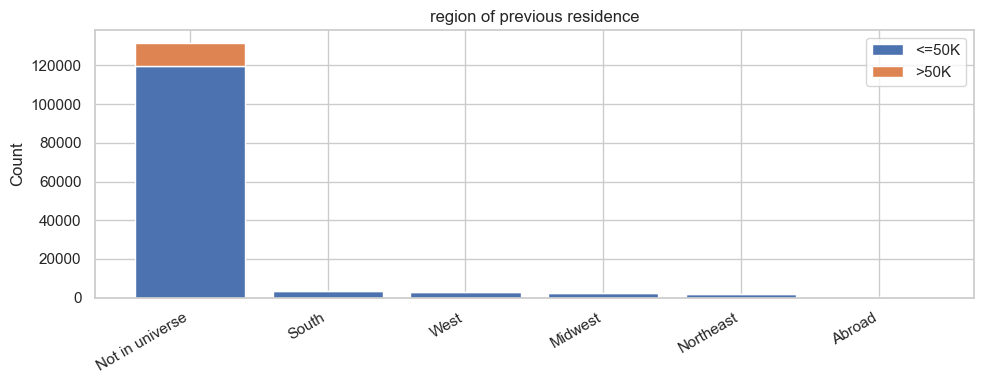

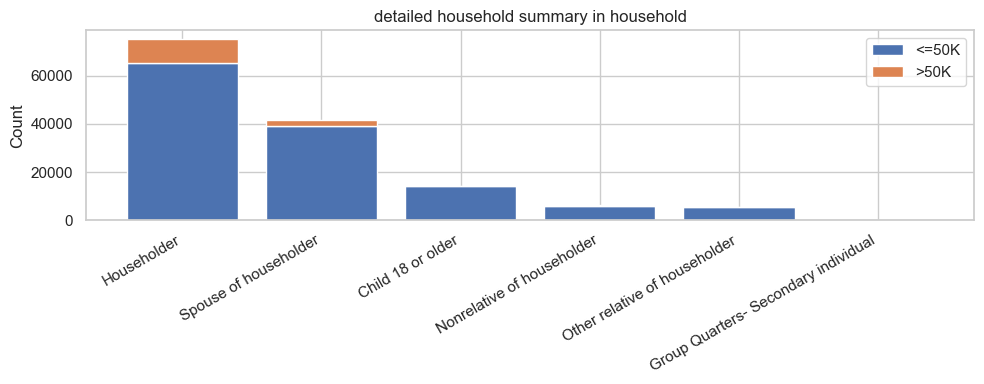

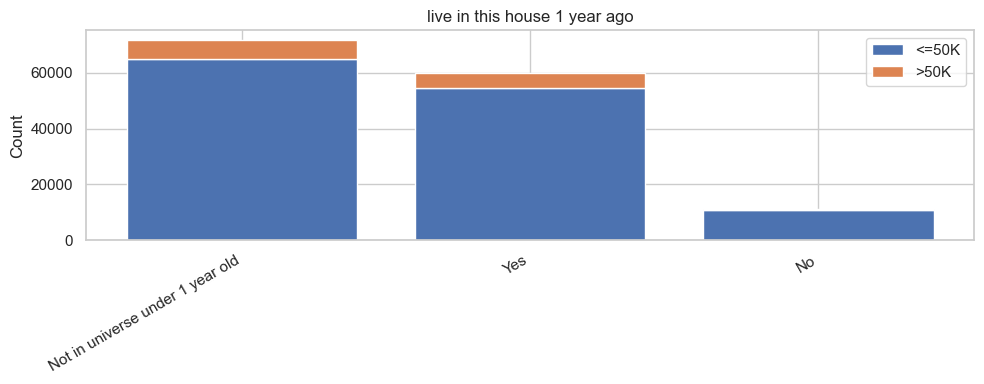

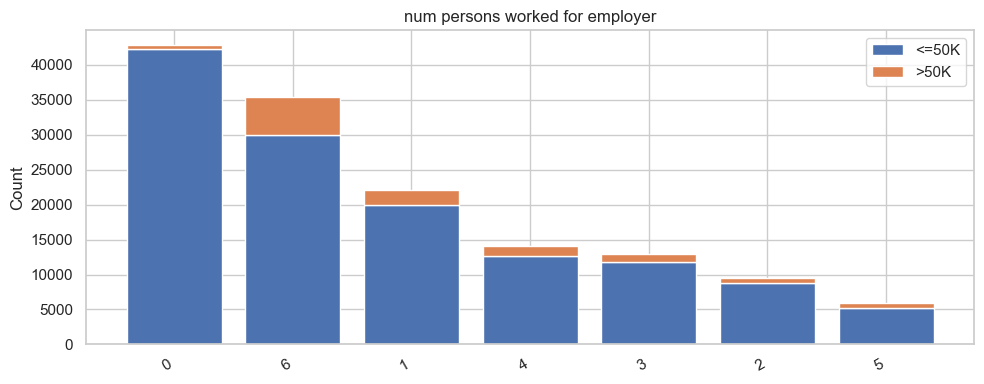

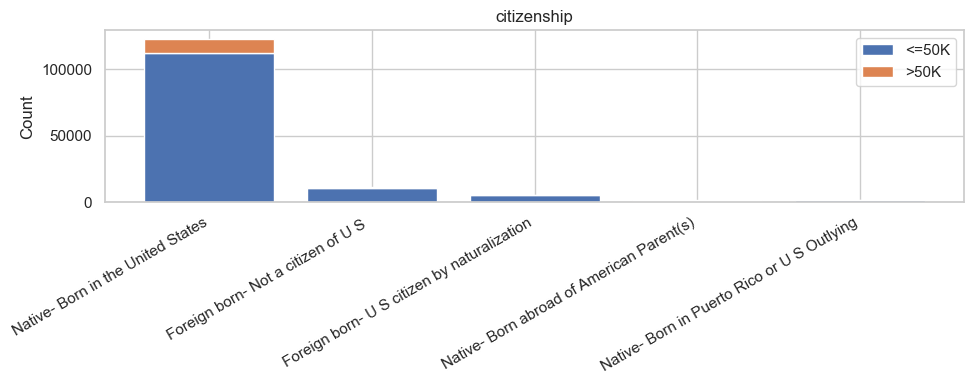

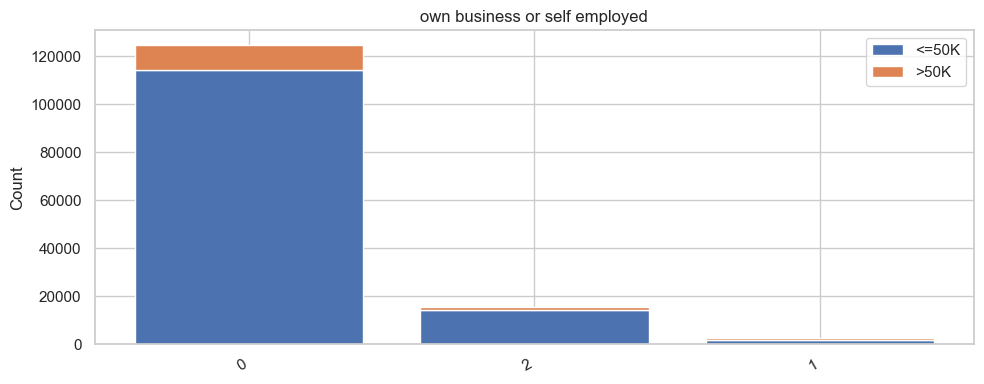

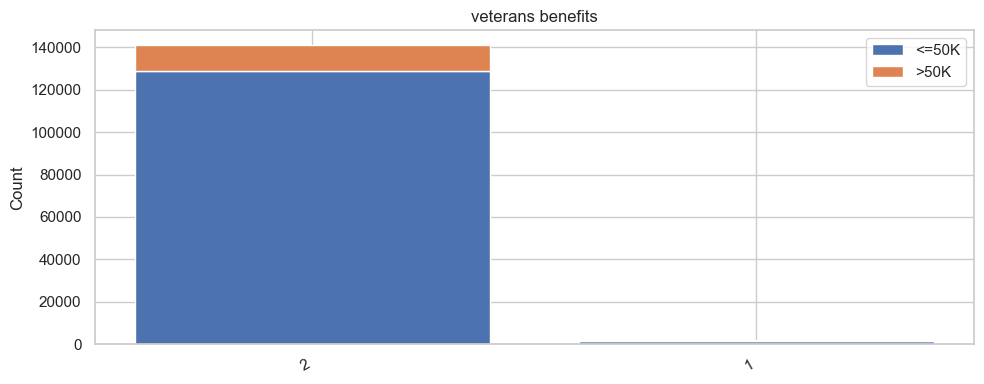

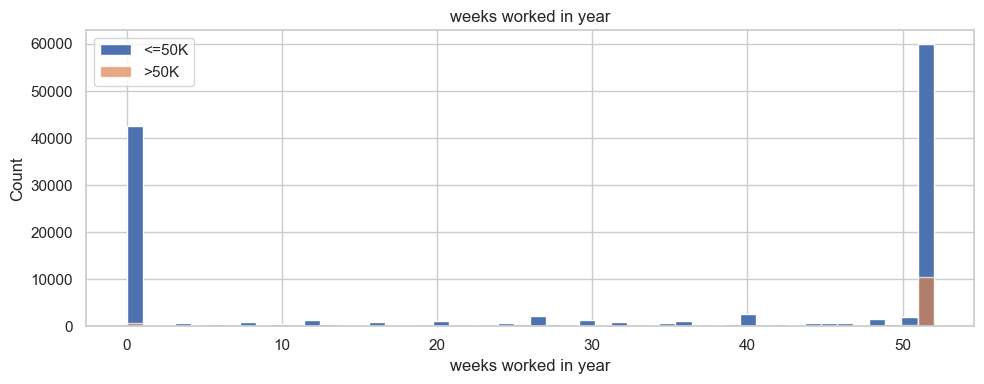

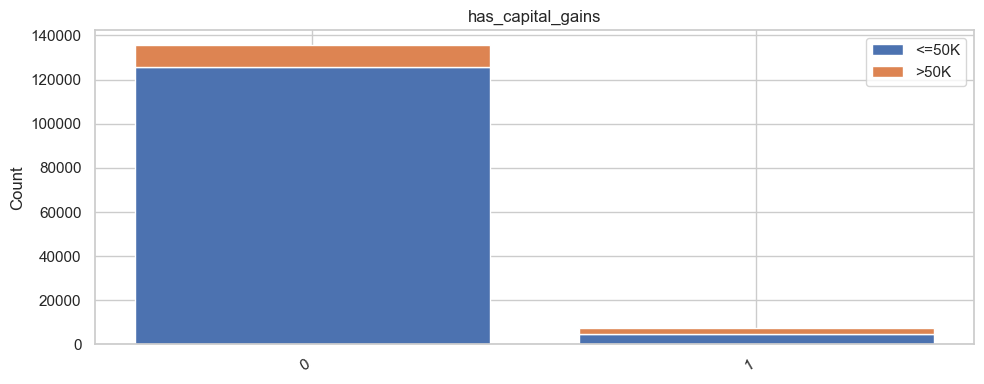

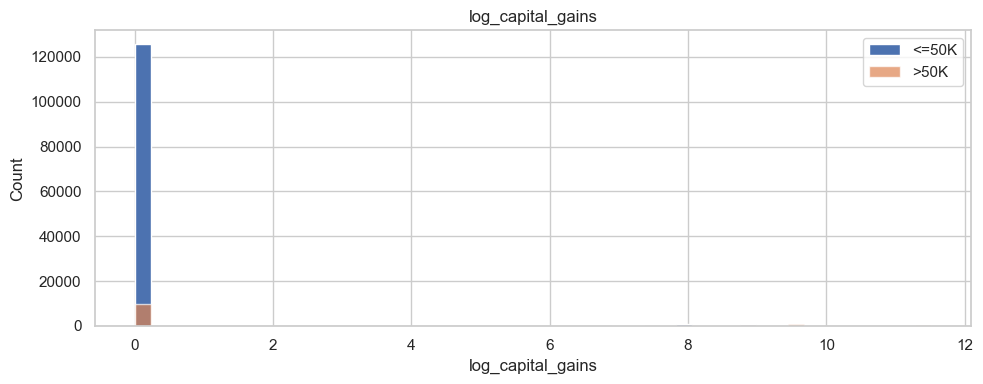

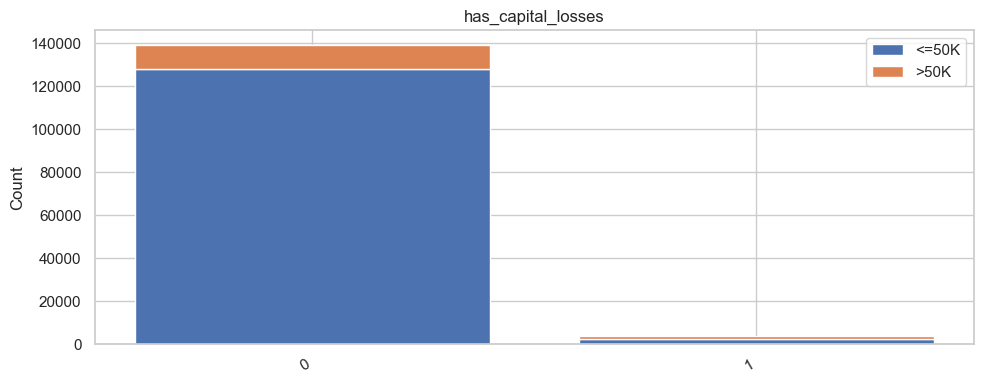

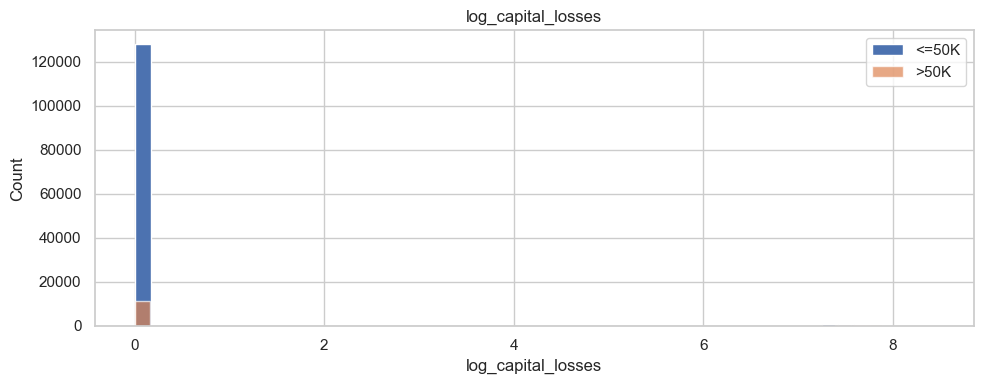

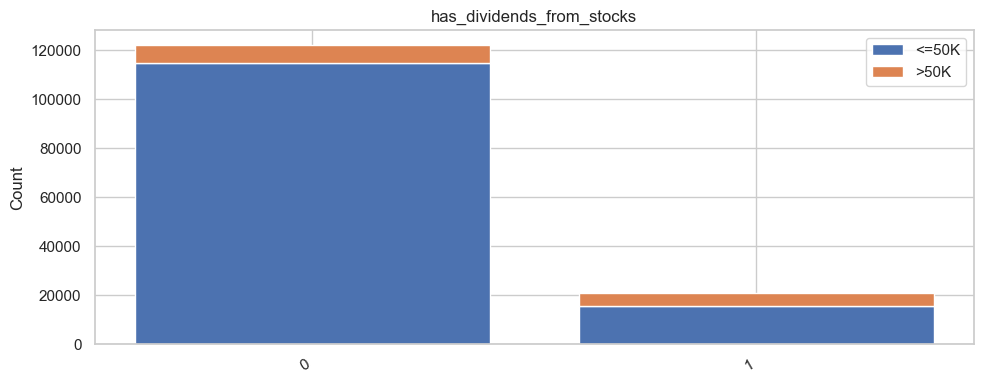

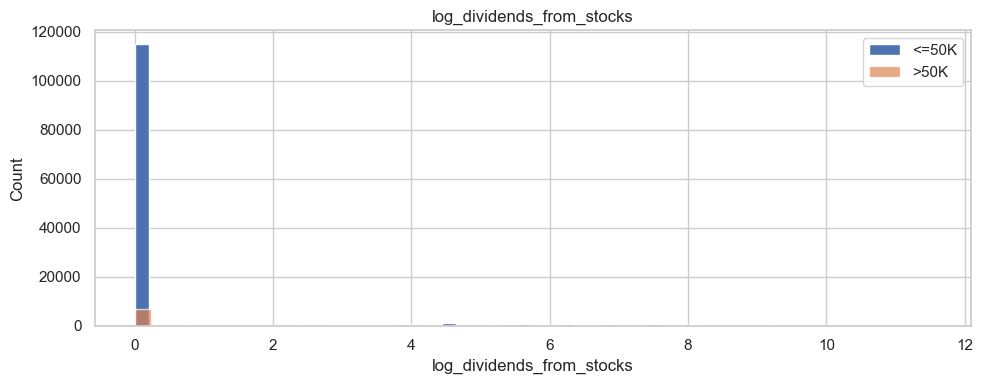

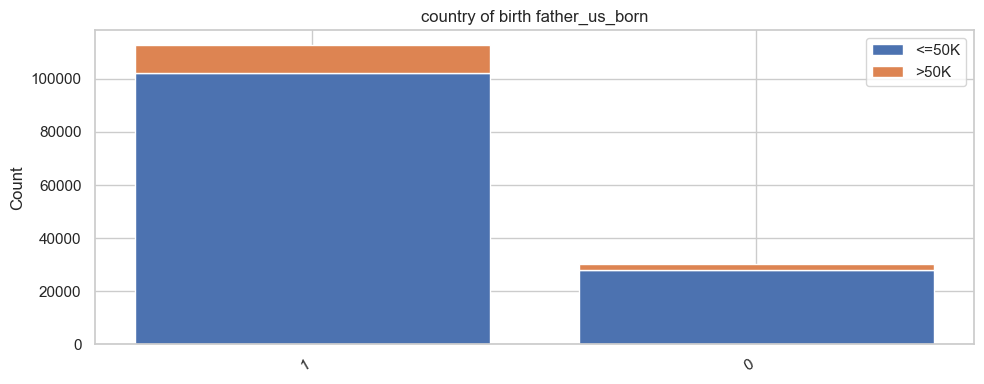

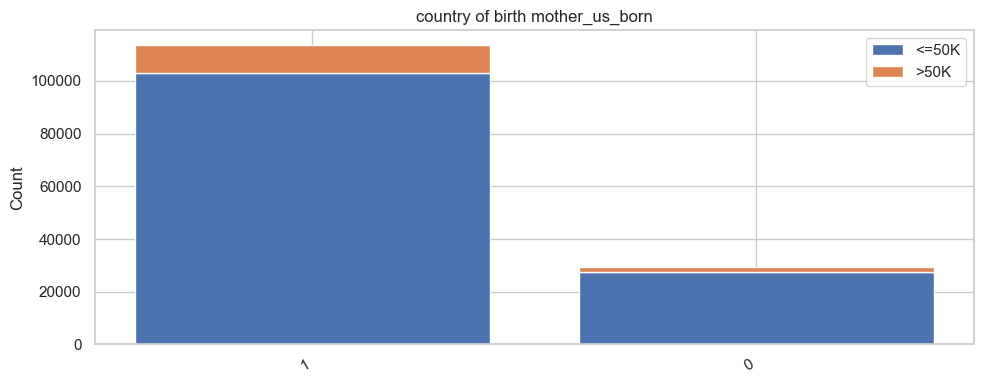

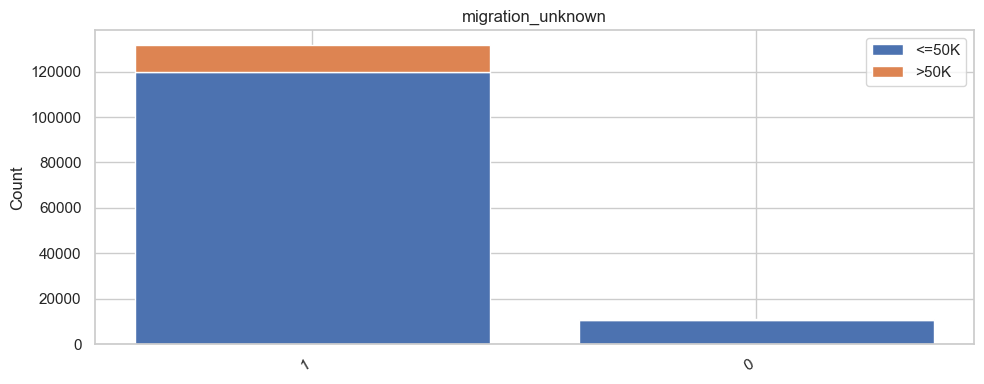

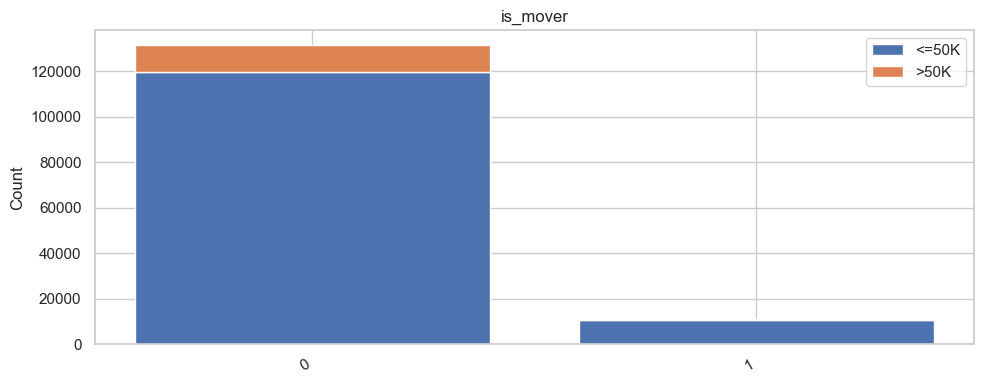

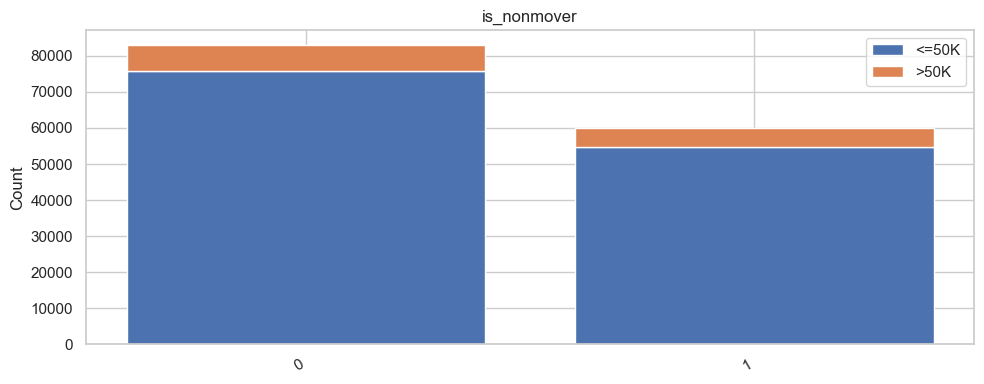

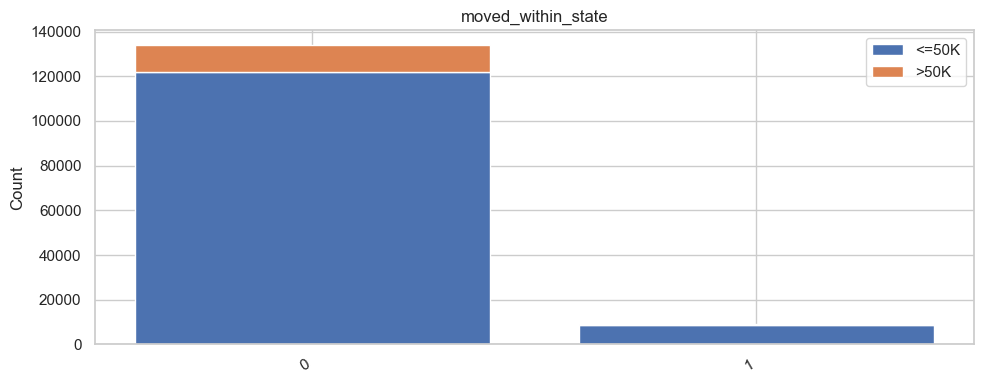

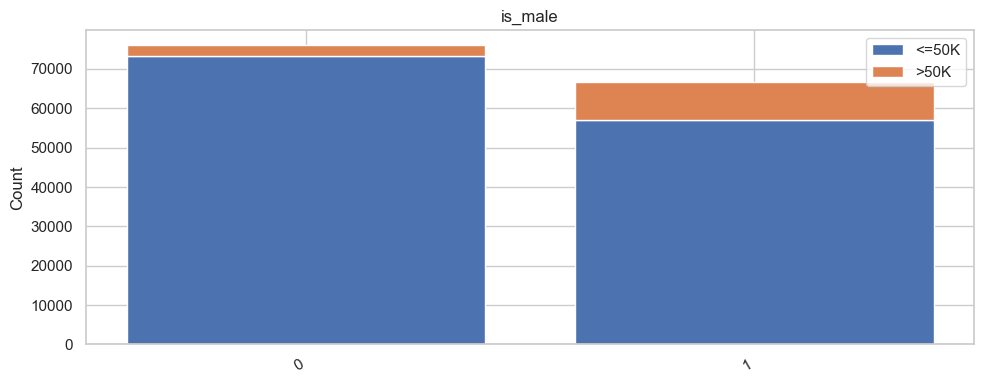

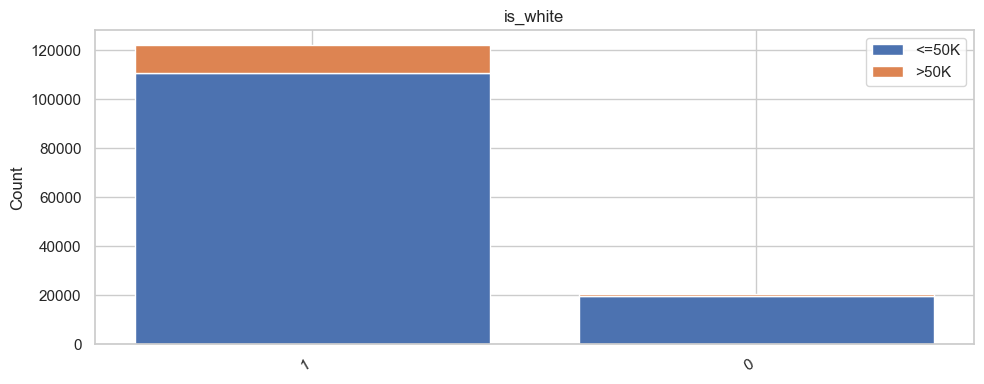

In [28]:
for f in X_fe.columns:
    plot_feature_vs_label(X_fe, y_fe, f)

## 7) Train/validation split

We apply a stratified split to preserve the class proportions in train and validation.

In [29]:
X_train, X_val, y_train, y_val = train_test_split(
    X_fe, y_fe,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_fe
)

print("Train positive rate:", float(y_train.mean()))
print("Val positive rate:  ", float(y_val.mean()))


Train positive rate: 0.08629201680672269
Val positive rate:   0.08630952380952381


## 8) Preprocessing pipeline

- Numeric: scale
- Categorical: one-hot encode


In [ ]:
num_cols = X_fe.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_fe.select_dtypes(include=["object"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ]
)

## 9) Model training + validation

Because of imbalance, we compare models with:
- average_precision (PR-AUC)
- roc_auc
- balanced_accuracy
- f1

In [ ]:
scoring = {
    "roc_auc": "roc_auc",
    "avg_precision": "average_precision",
    "balanced_acc": "balanced_accuracy",
    "f1": "f1",
    "accuracy": "accuracy",
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def eval_model_cv(name, clf):
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", clf)])
    scores = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1, error_score="raise")
    out = {k: float(np.mean(v)) for k, v in scores.items() if k.startswith("test_")}
    out["model"] = name
    return out

models = []

models.append(("DummyMostFrequent", DummyClassifier(strategy="most_frequent")))

models.append(("LogReg_balanced_L2",
               LogisticRegression(max_iter=3000, class_weight="balanced", solver="liblinear")))

models.append(("DecisionTree",
               DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced", max_depth=None)))

models.append(("RandomForest",
               RandomForestClassifier(
                   n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1,
                   class_weight="balanced_subsample"
               )))

models.append(("GradientBoosting",
               GradientBoostingClassifier(random_state=RANDOM_STATE)))


models.append(("XGBoost",
                XGBClassifier(
                    n_estimators=600,
                    learning_rate=0.05,
                    max_depth=4,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    reg_lambda=1.0,
                    objective="binary:logistic",
                    eval_metric="logloss",
                    random_state=RANDOM_STATE
                )))

rows = []
for name, clf in models:
    rows.append(eval_model_cv(name, clf))

cv_results = pd.DataFrame(rows).set_index("model").sort_values("test_avg_precision", ascending=False)
display(cv_results)


,test_roc_auc,test_avg_precision,test_balanced_acc,test_f1,test_accuracy
model,,,,,
XGBoost,0.932689,0.673943,0.720844,0.566518,0.939750
GradientBoosting,0.924087,0.642818,0.698130,0.527360,0.936598
LogReg_balanced_L2,0.920996,0.607121,0.844773,0.474182,0.836362
RandomForest,0.914845,0.600212,0.685597,0.497651,0.932581
DecisionTree,0.702104,0.251665,0.701676,0.447481,0.902118
DummyMostFrequent,0.500000,0.086292,0.500000,0.000000,0.913708


## 10) Fit best model on train, evaluate on validation

Pick the best model by **PR-AUC** (usually the most informative here).

Best model by CV avg_precision: XGBoost
Validation ROC-AUC: 0.9352300826244565
Validation PR-AUC: 0.6861079155172106

              precision    recall  f1-score   support

           0     0.9505    0.9873    0.9685     26095
           1     0.7717    0.4552    0.5726      2465

    accuracy                         0.9414     28560
   macro avg     0.8611    0.7212    0.7706     28560
weighted avg     0.9350    0.9414    0.9343     28560



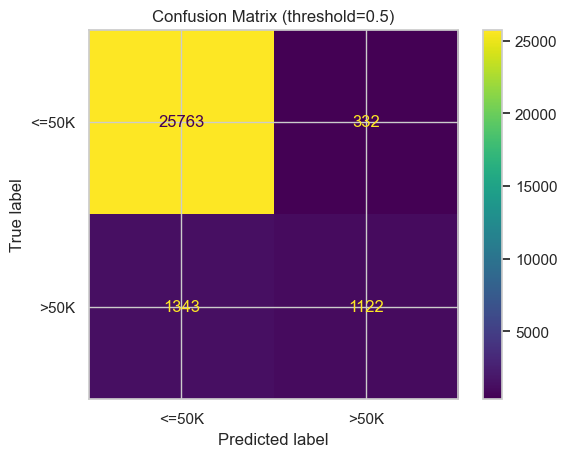

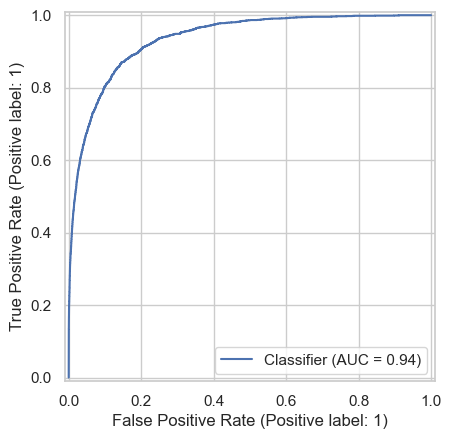

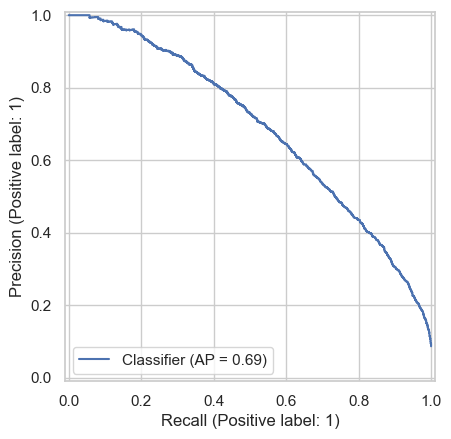

In [ ]:
best_name = cv_results.index[0]
print("Best model by CV avg_precision:", best_name)

best_clf = dict(models)[best_name]
best_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", best_clf)])

best_pipe.fit(X_train, y_train)

# Probabilities if available
if hasattr(best_pipe.named_steps["model"], "predict_proba"):
    val_proba = best_pipe.predict_proba(X_val)[:, 1]
else:
    # fallback for models without predict_proba
    val_proba = best_pipe.decision_function(X_val)
    val_proba = (val_proba - val_proba.min()) / (val_proba.max() - val_proba.min() + 1e-9)

val_pred = (val_proba >= 0.5).astype(int)

print("Validation ROC-AUC:", roc_auc_score(y_val, val_proba))
print("Validation PR-AUC:", average_precision_score(y_val, val_proba))
print()
print(classification_report(y_val, val_pred, digits=4))

cm = confusion_matrix(y_val, val_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["<=50K", ">50K"])
disp.plot(values_format="d")
plt.title("Confusion Matrix (threshold=0.5)")
plt.show()

RocCurveDisplay.from_predictions(y_val, val_proba)
plt.show()

PrecisionRecallDisplay.from_predictions(y_val, val_proba)
plt.show()

### Threshold tuning (PoC)

We can vary the threshold to match our business constraint:
- fixed marketing budget → target the top X% highest predicted probabilities
- limit false positives (avoid wasting spend) → higher threshold
- maximize recall of high-income customers → lower threshold

This cell shows performance at a few sample thresholds. If we wanted to target higher income individuals and needed our model to be more accurate, then we should lower the threshold to 0.3 or 0.4 (false negatives reduce from 1343 to 916). 

In [33]:
thresholds = [0.1, 0.2, 0.3, 0.5, 0.7]
rows = []
for t in thresholds:
    pred = (val_proba >= t).astype(int)
    cm = confusion_matrix(y_val, pred)
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    rows.append({"threshold": t, "precision": precision, "recall": recall, "tp": tp, "fp": fp, "fn": fn})
display(pd.DataFrame(rows))


,threshold,precision,recall,tp,fp,fn
0,0.1,0.380779,0.848682,2092,3402,373
1,0.2,0.511681,0.728600,1796,1714,669
2,0.3,0.610564,0.628398,1549,988,916
3,0.5,0.771664,0.455172,1122,332,1343
4,0.7,0.891386,0.289655,714,87,1751


### Explainability using regularized Logistic Regression (PoC)

For explainability, we also try to fit a sparse logistic regression (L1 / Elastic Net) to obtain an interpretable model that lists the most important features for predicting >$50K. This can be useful when model users want to know what signals are driving a certain prediction. It's also good for analyzing potential bias due to demographic features.


In [35]:
explain_model = LogisticRegressionCV(
    Cs=10,
    cv=cv,
    solver="saga",
    l1_ratios=[0.1, 0.5, 0.9],
    scoring="average_precision",
    class_weight="balanced",
    max_iter=5000,
    n_jobs=-1,
    refit=True,
    use_legacy_attributes=False
)

explain_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", explain_model)])
explain_pipe.fit(X_train, y_train)

# Evaluate
if hasattr(explain_pipe.named_steps["model"], "predict_proba"):
    proba = explain_pipe.predict_proba(X_val)[:, 1]
else:
    proba = explain_pipe.decision_function(X_val)
    proba = (proba - proba.min()) / (proba.max() - proba.min() + 1e-9)

print("Explainable model PR-AUC:", average_precision_score(y_val, proba))
print("Explainable model ROC-AUC:", roc_auc_score(y_val, proba))


Explainable model PR-AUC: 0.6224300968536198
Explainable model ROC-AUC: 0.9227246754427865


In [40]:
# extract feature names from the fitted preprocessor
preprocess = explain_pipe.named_steps["preprocess"]

ohe = preprocess.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = list(num_cols) + list(cat_feature_names)

coef = explain_pipe.named_steps["model"].coef_.ravel()

coef_df = pd.DataFrame({"feature": feature_names, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

display(coef_df.head(25))

,feature,coef,abs_coef
7,log_capital_gains,5.091896,5.091896
6,has_capital_gains,-4.879186,4.879186
9,log_capital_losses,1.686686,1.686686
8,has_capital_losses,-1.500663,1.500663
31,education_Graduate degree,1.428199,1.428199
105,tax filer stat_Nonfiler,-1.357720,1.357720
78,major occupation code_Private household services,-1.254010,1.254010
93,full or part time employment stat_Children or Armed Forces,-1.170233,1.170233
28,class of worker_Without pay,-1.164291,1.164291
70,major occupation code_Armed Forces,1.120865,1.120865


## 14) Next steps / extensions

- Add **calibration** (Platt/isotonic) if you need well-calibrated probabilities
- Add **cost-sensitive thresholding** (marketing ROI)
- Compare with **LightGBM/CatBoost** (handles categorical better; often best performance)
- Add a fairness/bias check (e.g., group metrics by sex/race) before deploying
